## Importing Libraries 

In [23]:
import pandas as pd 
import numpy as np 
import json 
import IPython

from binascii import a2b_base64
import urllib
import urllib.request

from IPython.display import Image

from IPython.core.debugger import Pdb; 
!pip install pymssql
import pymssql


# Corpus Processing
! pip install unidecode
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics      import silhouette_samples, silhouette_score
from wordcloud            import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords, twitter_samples
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


### Cheking if the latex to image conveersion is correct for the question. 

In [27]:
bio_data = pd.read_csv('data-bio.csv')
bio_data

,CourseName,SubjectName,TopicName,ChapterName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex
0,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Lymphatic Organs: Spleen -1,37496,NaN,Example,Removal of which organ will have least effect ...
1,7/8 CBSE,Biology,Human Physiology,Neural Control and Coordination,Functions of Ear,37798,NaN,Example,Our ear can hear sound waves of the frequency ...
2,7/8 CBSE,Biology,Ecology,Environmental Issues,EL NINO Effect,61282,"<html><body><div><img src= ""data:img/jpg;base6...",Example,"Temperature inversions, heat islands, and dust..."
3,7/8 CBSE,Biology,Biology in Human Welfare,Human Health and Disease,Kwashiorkor,35703,NaN,Trial,Kwashiorkor disease is due to deficiency of :\...
4,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Important Points-2,37463,NaN,Example,First heart transplant was performed by\n(A) W...
...,...,...,...,...,...,...,...,...,...
1923,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Important Points-2,64178,NaN,Example,Father of Angiology is-\n(A) William Harvey\n(...
1924,7/8 CBSE,Biology,Biology in Human Welfare,Human Health and Disease,Non- communicable Diseases,34837,NaN,Example,can cause cancer in humans.\n(A) Chlorides\n(B...
1925,7/8 CBSE,Biology,Human Physiology,Chemical Coordination and Integration,Gastrointestinal Hormones,133214,NaN,Example,Secretin is a gastrointestinal tract hormone t...
1926,7/8 CBSE,Biology,Ecology,Biodiversity and Conservation,Ex situ Conservation,122264,NaN,Example,Which one of the following is not used for ex ...


In [28]:
# checking how much data have image information present 
image_data = bio_data[pd.isnull(bio_data.imageHTML) == False]
print('questions with image are ',image_data.shape[0])
image_data.to_csv('questions_with_image.csv')

image_data[['QuestionId','imageHTML','Q_Latex']].to_csv('questions_with_image.csv')

questions with image are  80


### Taking all questions with non nan  imageHTML and checking if latex files are corretly converted to images 


In [ ]:
# This will loop over all images and show its latex and image 
for index, row in image_data.iterrows():
    image_html = row['imageHTML'];
    image_html=image_html.split('src= "')
    image_url = image_html[1].split('" >')
    data = image_url[0]
    response = urllib.request.urlopen(data)
    with open('image.jpg', 'wb') as f:
        f.write(response.file.read())
    question_latex = row['Q_Latex'];
    print(question_latex). # print the question latex 
    img = Image(filename='image.jpg') 
    display(img)     # display image 
    Pdb().set_trace()
    # type continue in text box to go to next image, quit() to exit the loop 
    
    

### Codes for pre processing and splitting data 

In [53]:
# takes in data with appropiate Example and Trial labels and splits them into train and test data 
def example_trial_split(data):

  example_data = data[data.UseAs == 'Example'] # Use data with example label 
  print('number of example data are', example_data.shape[0])
  trial_data = data[data.UseAs == 'Trial']  # Use data with trial label 
  print('number of trial data are', trial_data.shape[0])

  trial_data.to_csv('trial_data_bio.csv')
  example_data.to_csv('example_data_bio.csv')

  return trial_data, example_data

In [30]:
# extracting Q_latex column 


# Defining functions for preprocessing step to remove latex specific characters and punctuations

# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]


# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [31]:
## matrix to store latex keywords and other words which does not add any specific meaning to the question 
latex_keywords=['begin','end','mathrm','Idots''idots','quad','a','b','c','d','i','ii','iii','iv','vii','longrightarrow',       
                'hline','rightarrow','column','text','array','begin','end','III','nm','none','one','frac'];

                
question_types=['true','false','assertion','asassertion','reason','correct','explanation','incorrect','questions','option','options'
               'statement','carefully','followed','following','incorrect','statements',
                 'assertion',
                 'statement',
                 'contains',
                 'select',
                 'reason',
                 'two',
                 'options',
                 'question',
                 'describes',
                 'answer',
                 'best',
                 'basis',
                 'correctexplanation',
                 'readthem',
                 'you',
                 'responses',
                 'answering',
                 'consist','(',')','_']


In [32]:
# main pre processing step 
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')  # defining stopwords from english language 
param_stemmer = SnowballStemmer('english')#defining stemmer to convert words to their root form 

## This code removes the punctuation, latex keywords and garbage values, can be customized according to need 
def preProcess(Question_text):
    for question in Question_text:
            index = Question_text.index(question)
            Question_text[index] = Question_text[index].replace(',', '')         # Removes commas
            Question_text[index] = Question_text[index].replace('\\', '')        # Removes \
            Question_text[index] = Question_text[index].replace('\n', '')        # removed newline
            Question_text[index] = Question_text[index].replace('-', '')        # removed newline
            Question_text[index] = Question_text[index].replace('~', '')        # Removes -
            Question_text[index] = Question_text[index].replace('=', '')        # Removes =



            Question_text[index] = Question_text[index].casefold()               # Makes all letters lowercase
            Question_text[index] = re.sub('\W_',' ', Question_text[index])       # removes specials characters 
            Question_text[index] = re.sub("\d"," ", Question_text[index])       # removes numbers
            listOfTokens = word_tokenize(Question_text[index])
            twoLetterWord = twoLetters(listOfTokens)
            

            listOfTokens = removeWords(listOfTokens, latex_keywords)    #remove all the latex keywords from our data
            listOfTokens = removeWords(listOfTokens, question_types)     #words such as assertion,reason,true,false etc
            listOfTokens = removeWords(listOfTokens, stopwords)
            listOfTokens = removeWords(listOfTokens, twoLetterWord)
            


            Question_text[index]   = " ".join(listOfTokens)
            Question_text[index] = unidecode(Question_text[index])
      
    return Question_text






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
# Functions for K means visualizations 
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
  # returns the top features of a cluster
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
  # makes barplot of the top features of a cluster in form a bar plot 
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [34]:
# get top features of individual cluster 
def get_top_features_cluster_ind(tf_idf_array, prediction, n_feats,lab):
    labels = np.unique(prediction)
    dfs = []
    label = lab;
    id_temp = np.where(prediction==label) # indices for each cluster
    x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
    sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means]
    df = pd.DataFrame(best_features, columns = ['features', 'score']) 
    return df
  

In [35]:
# pre processing step 
# akes in example and trial data and removes un necessary columns and then renames column, label specifies based on which column 
# prediction is to be made, eg - KSCName, Chapter etc 
def preProcessDeepLearning(example_data , trial_data , label):
  example_data['split']= 'train' # use label train for example data 
  test_data = trial_data
  test_data['split'] = 'test'
  merged_test_train_data = example_data.append(test_data)
  merged_test_train_data =merged_test_train_data[['Q_Latex',label,'split']] # select the column you want as label
  merged_test_train_data.rename(columns = {'Q_Latex':'sentence',	label:'label'}, inplace = True)
  return merged_test_train_data;





In [36]:
# Define a function to compute the max length of sequence
def max_length(sequences):
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [37]:
# function for making prediction from a CNN model 
def make_pred(model,test_x,corpus):
  tokenizer = Tokenizer(oov_token=oov_tok)
  tokenizer.fit_on_texts(train_x) # fit tolenizer on test dataset 
  training_sequences = tokenizer.texts_to_sequences(train_x)
  test_sequences = tokenizer.texts_to_sequences(test_x) #generate sequence out of text 
  max_len = max_length(training_sequences)  # get max lenghth of question in the corpus


  Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
  Xtrain = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


  predictions= model.predict(Xtest,verbose= 0 ) # make predictions
  first_predictions= np.argmax(predictions,axis= 1).tolist() # get prediction of most confidance 

  test_corpus = corpus[corpus['split'] == 'test']
  correct_code = test_corpus['label'].tolist() # correct label
  correct_labels = [chapter_mapping[chapter_mapping['label_code']== pred_label]['label'].tolist()[0]
                            for pred_label in correct_code ]
  first_predicted_labels = [chapter_mapping[chapter_mapping['label_code']== pred_label]['label'].tolist()[0]
                            for pred_label in first_predictions ]
  test_corpus['First_prediction'] = first_predicted_labels
  test_corpus['CorrectLabel'] = correct_labels
  test_corpus[test_corpus['First_prediction'] == test_corpus['CorrectLabel']]
  return test_corpus;  # test corpus with column for predicted label 


In [38]:
# creates a tokenizer to fit on some sequences 
def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

In [39]:
def train_test_split(corpus):
  # Separate the sentences and the labels
  # Separate the sentences and the labels for training and testing

  train_x = list(corpus[corpus.split=='train'].sentence)
  train_y = np.array(corpus[corpus.split=='train'].label)

  test_x = list(corpus[corpus.split=='test'].sentence)
  test_y = np.array(corpus[corpus.split=='test'].label)
  print('length of test data is - ', len(test_x))
  print('length of train data is - ', len(train_x))
  return train_x,train_y, test_x,test_y


In [40]:
# compares top 3 prediction of model with correct KSC and calculates accuracy using 9 models 
# First using the total subject model we predict the subject of the question 
# according to subject we choose appropiate models and tokenizer for chapter and KSC predictions 
# Calculate accuracy based on top 3 KSC prediction and see if any one mathes with correct KSC label  
def accuracyTopThreeKSCText(Xtest):

    pred_seq_wise = []
    for i in range(0,len(Xtest)-1):
      ques_text = test_x[i:i +1]
      test_ques = tokenizer_total.texts_to_matrix(ques_text, mode='freq')

      subject_pred= model_subjcet_total.predict(test_ques)
      subject_pred= np.argmax(subject_pred,axis= 1).tolist()
      subject_pred=subject_pred[0]
      pred_subject_label = subject_mapping[subject_mapping['label_code'] == subject_pred].label.tolist()[0] #predicted Subject 

      if(pred_subject_label != trial_data.SubjectName.tolist()[i]): # if subject predicted wrong then return 
        pred_seq_wise.append(0) ;

      else :
        if(pred_subject_label == 'Biology'):
          test_ques = tokenizer_bio.texts_to_matrix(ques_text, mode='freq')
          chapter_pred= model_chapter_bio.predict(test_ques)  # seletct appropiate Chapter model 
          ksc_model = model_KSC_bio # seletct appropiate KSC model 
          pred_prob = chapter_mapping_bio
          ksc_mapping = KSC_mapping_bio
          pred_prob['Probability']=chapter_pred[0]
          valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
          pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]  # predicted chapter label 

        elif(pred_subject_label == 'Chemistry'): 
          test_ques = tokenizer_chm.texts_to_matrix(ques_text, mode='freq')
          chapter_pred= model_chapter_chm.predict(test_ques)
          ksc_model = model_KSC_chm
          pred_prob = chapter_mapping_chm
          ksc_mapping = KSC_mapping_chm
          pred_prob['Probability']=chapter_pred[0]
          valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
          pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

        elif(pred_subject_label == 'Physics'):
          test_ques = tokenizer_phy.texts_to_matrix(ques_text, mode='freq')
          chapter_pred= model_chapter_phy.predict(test_ques)
          pred_prob = chapter_mapping_phy
          ksc_model = model_KSC_phy
          ksc_mapping = KSC_mapping_phy
          pred_prob['Probability']=chapter_pred[0]
          valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
          pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

        elif(pred_subject_label == 'Maths'):
          test_ques = tokenizer_math.texts_to_matrix(ques_text, mode='freq')
          chapter_pred= model_chapter_math.predict(test_ques)
          pred_prob = chapter_mapping_math
          ksc_model = model_KSC_math
          ksc_mapping = KSC_mapping_math
          pred_prob['Probability']=chapter_pred[0]
          valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
          pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

        if(pred_chapter_label != trial_data.ChapterName.tolist()[i]):
            pred_seq_wise.append(0) ;

        else: 
          KSC_pred = ksc_model.predict(test_ques) #predicted kSC label 
          pred_prob = ksc_mapping
          pred_prob['Probability']=KSC_pred[0]
          valid_KSC = trial_data[trial_data['ChapterName']==pred_chapter_label ].KSCText.unique() # KSC present in the particular chapter predicted before
                                                                                                # only these KSC will be used for prediction 
          try:
            correct_KSC = trial_data.KSCText.tolist()[i] # correct KSC label of data 
            correct_KSC_ind=total_KSC_list.index(correct_KSC)
            pred_KSC_label_first = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[0] # first KSC prediction 
          
            pred_KSC_label_second = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[1] # Second KSC prediction 
            pred_KSC_label_third = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[2] # Third KSC prediction 
      
            
            if(pred_KSC_label_first == correct_KSC or pred_KSC_label_second == correct_KSC or pred_KSC_label_third == correct_KSC):
              result = 1;
              pred_seq_wise.append(1) ;
              
                
            else :
              result = 0 ;
              pred_seq_wise.append(0) ;
            
          except :
            try:
              if(pred_KSC_label_first == correct_KSC or pred_KSC_label_second == correct_KSC):
                result = 1;
                pred_seq_wise.append(1) ;
              else :
                result = 0 ;
                pred_seq_wise.append(0) ;
                
            except :
                if(pred_KSC_label_first == correct_KSC):
                  result = 1;
                  pred_seq_wise.append(1) ;
                else :
                  result = 0 ;
                  pred_seq_wise.append(0) ;



    return pred_seq_wise #return array of results for all test data 
        

          


In [41]:
# compares top 3 cluster prediction of model with correct KSC cluster and calculates accuracy using 9 models 
# Calculate accuracy based on top 3 KSC Cluster prediction and see if any one mathes with correct Cluster 
def accuracyTopThreeKSCClsuter(Xtest,test_with_cluster):
  pred_seq_wise = []

  for i in range(0, len(Xtest)-1):
    ques_text = test_x[i:i +1]
    test_ques = tokenizer_total.texts_to_matrix(ques_text, mode='freq')

    subject_pred= model_subjcet_total.predict(test_ques)
    subject_pred= np.argmax(subject_pred,axis= 1).tolist()
    subject_pred=subject_pred[0]
    pred_subject_label = subject_mapping[subject_mapping['label_code'] == subject_pred].label.tolist()[0]
    if(pred_subject_label != trial_data.SubjectName.tolist()[i]):
      pred_seq_wise.append(0) ;

    else :
      if(pred_subject_label == 'Biology'):
        test_ques = tokenizer_bio.texts_to_matrix(ques_text, mode='freq')
        chapter_pred= model_chapter_bio.predict(test_ques)
        ksc_model = model_KSC_bio
        pred_prob = chapter_mapping_bio
        ksc_mapping = KSC_mapping_bio
        pred_prob['Probability']=chapter_pred[0]
        valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
        pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

      elif(pred_subject_label == 'Chemistry'): 
        test_ques = tokenizer_chm.texts_to_matrix(ques_text, mode='freq')
        chapter_pred= model_chapter_chm.predict(test_ques)
        ksc_model = model_KSC_chm
        pred_prob = chapter_mapping_chm
        ksc_mapping = KSC_mapping_chm
        pred_prob['Probability']=chapter_pred[0]
        valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
        pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

      elif(pred_subject_label == 'Physics'):
        test_ques = tokenizer_phy.texts_to_matrix(ques_text, mode='freq')
        chapter_pred= model_chapter_phy.predict(test_ques)
        pred_prob = chapter_mapping_phy
        ksc_model = model_KSC_phy
        ksc_mapping = KSC_mapping_phy
        pred_prob['Probability']=chapter_pred[0]
        valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
        pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

      elif(pred_subject_label == 'Maths'):
        test_ques = tokenizer_math.texts_to_matrix(ques_text, mode='freq')
        chapter_pred= model_chapter_math.predict(test_ques)
        pred_prob = chapter_mapping_math
        ksc_model = model_KSC_math
        ksc_mapping = KSC_mapping_math
        pred_prob['Probability']=chapter_pred[0]
        valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
        pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]

      if(pred_chapter_label != trial_data.ChapterName.tolist()[i]):
          pred_seq_wise.append(0) ;

      else: 
        KSC_pred = ksc_model.predict(test_ques)
        pred_prob = ksc_mapping
        pred_prob['Probability']=KSC_pred[0]
        valid_KSC = trial_data[trial_data['ChapterName']==pred_chapter_label ].KSCText.unique()
        try:
          correct_KSC = trial_data.KSCText.tolist()[i]
          correct_KSC_cluster = test_with_cluster[test_with_cluster['KSCText']== correct_KSC].KSCClusterName.tolist()[0];


          pred_KSC_label_first = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[0];
          pred_KSC_cluster_first=test_with_cluster[test_with_cluster['KSCText']==pred_KSC_label_first].KSCClusterName.tolist()[0];

          pred_KSC_label_second=[]
          pred_KSC_cluster_second=[]
          pred_KSC_label_second = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[1];
          pred_KSC_cluster_second=test_with_cluster[test_with_cluster['KSCText']==pred_KSC_label_second].KSCClusterName.tolist()[0];

          pred_KSC_label_third=[]
          pred_KSC_cluster_third=[]
          pred_KSC_label_third = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[2];
          pred_KSC_cluster_third=test_with_cluster[test_with_cluster['KSCText']==pred_KSC_label_third].KSCClusterName.tolist()[0];

    
          
          if(pred_KSC_cluster_first == correct_KSC_cluster or pred_KSC_cluster_second == correct_KSC_cluster or pred_KSC_cluster_third == correct_KSC_cluster):
            result = 1;
            pred_seq_wise.append(1) ;
          else :
            result = 0 ;
            pred_seq_wise.append(0) ;
        except :
          try:
            if(pred_KSC_cluster_first == correct_KSC_cluster or pred_KSC_cluster_second == correct_KSC_cluster):
              result = 1;
              pred_seq_wise.append(1) ;
            else :
              result = 0 ;
              pred_seq_wise.append(0) ;
              
          except :
              if(pred_KSC_cluster_first == correct_KSC_cluster):
                result = 1;
                pred_seq_wise.append(1) ;
              else :
                result = 0 ;
                pred_seq_wise.append(0) ;
  return pred_seq_wise

## Models

In [49]:
def simple_NN_model(no_label = 10, max_len = 100 ):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(max_len,)),  # first hidden layer 
        tf.keras.layers.Dropout(0.5),         # droupout layer
        tf.keras.layers.Dense( units=no_label, activation='softmax') # prediction layer with activation function
    ])
     
    return model

In [43]:
def two_layer_NN_model(no_label = 10, max_len = 100 ):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(max_len,)),   #first hidden layer 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(max_len,)),    #Second hidden layer  hidden layer 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=no_label, activation='softmax')
    ])
    
  
    return model

In [44]:
### CNN model 
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm

def define_model_cnn(filters = 100, kernel_size = 3, activation='relu', input_dim = None, output_dim=300, len_max = None, no_labels= 3 ):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,     # vocab size - Size of vocabulary, can get this from tokennizer 
                                  output_dim=output_dim,    # output dim of embedding layer 
                                  input_length=len_max,     # max length of question in the train corpus 
                                  input_shape=(len_max, )), 
        
        tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation = activation, 
                               # set 'axis' value to the first and second axis of conv1D weights (rows, cols)
                               kernel_constraint= MaxNorm( max_value=3, axis=[0,1])),
        
        tf.keras.layers.MaxPool1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation=activation, 
                              # set axis to 0 to constrain each weight vector of length (input_dim,) in dense layer
                              kernel_constraint = MaxNorm( max_value=3, axis=0)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=no_labels, activation='softmax')
    ])
    
    model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#     model.summary()
    return model

In [45]:
vocab_size = 5000
model = define_model_cnn(len_max = 140)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 300)          1500000   
                                                                 
 conv1d (Conv1D)             (None, 138, 100)          90100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 69, 100)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6900)              0         
                                                                 
 dropout (Dropout)           (None, 6900)              0         
                                                                 
 dense (Dense)               (None, 10)                69010     
                                                        

In [46]:
class myCallback(tf.keras.callbacks.Callback):
    # Overide the method on_epoch_end() for our benefit
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training=True


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=20, verbose=2, 
                                             mode='auto', restore_best_weights=True)
#callbacks = myCallback()

In [47]:
# Parameter Initialization

def run_cnn_model(no_labels, activation, kernel_size,train_x,test_x,test_y ):
      trunc_type='post'
      padding_type='post'
      oov_tok = "<UNK>"
      filters = 100
 

      columns = ['Activation', 'Filters', 'Acc']
      record = pd.DataFrame(columns = columns)


      # encode data using
      # Cleaning and Tokenization
      tokenizer = Tokenizer(oov_token=oov_tok)
      tokenizer.fit_on_texts(train_x)

      # Turn the text into sequence
      training_sequences = tokenizer.texts_to_sequences(train_x)
      test_sequences = tokenizer.texts_to_sequences(test_x)

      max_len = max_length(training_sequences)

      # Pad the sequence to have the same size
      Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
      Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

      word_index = tokenizer.word_index
      vocab_size = len(word_index)+1

      # Define the input shape
      model = define_model_cnn(filters, kernel_size, activation, input_dim=vocab_size, len_max=max_len,no_labels = no_labels)
        # Train the model
      model.fit(Xtrain, train_y, batch_size=50, epochs=60, verbose=2, callbacks=[callbacks], validation_data=(Xtest, test_y))

      # evaluate the model
      loss, acc = model.evaluate(Xtest, test_y, verbose=0)
      print('Test Accuracy: {}'.format(acc*100))

      parameters = [activation, kernel_size]
      entries = parameters + [acc]

      temp = pd.DataFrame([entries], columns=columns)
      record = record.append(temp, ignore_index=True)
      print()
      print(record)
      print()
      return  model

## Creating test and train data for cluster analysis 

In [ ]:
data_bio = pd.read_csv('data-bio.csv').reset_index()
trial_data_bio, example_data_bio = example_trial_split(data_bio)

number of example data are 1517
number of trial data are 411


In [ ]:
# exploring the example_data 
print('Number of topics covered by example data',(example_data_bio['TopicName'].unique()).shape[0])
print('Number of Chapters covered by example data',(example_data_bio['ChapterName'].unique()).shape[0])
print('Number of KSC covered by example data',(example_data_bio['KSCText'].unique()).shape[0])
print('Questions lacking latex data ', sum(pd.isnull(example_data_bio['Q_Latex'])) )

Number of topics covered by example data 8
Number of Chapters covered by example data 27
Number of KSC covered by example data 259
Questions lacking latex data  0


## Analysing data by topic, chapter and KSC text 


### Maximum questions are of Human Physiology followed by Genetics and Evolution

In [ ]:
### print('Columns in example data are ',example_data.columns)
grouped_by_chapter = example_data_bio.groupby('ChapterName').count()
grouped_by_chapter=grouped_by_chapter.sort_values(by = 'index',ascending=False)
grouped_by_chapter=grouped_by_chapter[grouped_by_chapter['index']>20]
grouped_by_chapter

,index,CourseName,SubjectName,TopicName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex
ChapterName,,,,,,,,,
Principles of Inheritance and Variation,287,287,287,287,287,287,12,287,287
Chemical Coordination and Integration,227,227,227,227,227,227,8,227,227
Biodiversity and Conservation,160,160,160,160,160,160,5,160,160
Human Reproduction,124,124,124,124,124,124,2,124,124
Neural Control and Coordination,84,84,84,84,84,84,2,84,84
Human Health and Disease,79,79,79,79,79,79,2,79,79
Molecular Basis of Inheritance,66,66,66,66,66,66,5,66,66
Cell Cycle and Cell Division,64,64,64,64,64,64,7,64,64
Microbes in Human Welfare,58,58,58,58,58,58,2,58,58


### We take only chapters which have > 20 questions avaialbe. Number of such chapters are 15

In [ ]:
abundant_chapters= grouped_by_chapter.index.tolist()
example_data_filtered_bio= example_data_bio[example_data_bio['ChapterName'].isin(abundant_chapters)]
trial_data_filtered_bio= trial_data_bio[trial_data_bio['ChapterName'].isin(abundant_chapters)]
example_data_filtered_bio.to_csv('example_data_filtered_bio.csv')
trial_data_filtered_bio.to_csv('trial_data_filtered_bio.csv')
print('Length of filtered example data is ',len(example_data_filtered_bio))
print('Length of filtered trial data is ',len(trial_data_filtered_bio))



Length of filtered example data is  1376
Length of filtered trial data is  375


### Questions belonging to Bacteria: Role in Agriculture and Industry KSC cluster has maximum number of questions 

In [ ]:
grouped_ksc_text = example_data_bio.groupby('KSCText').count()
grouped_ksc_text.sort_values(by = 'index',ascending=False)
kcs_abundant = grouped_ksc_text[grouped_ksc_text['index']> 5].index #  Prints KSC text which occur 
print('KSC which have more than 5 questions- ',len(kcs_abundant))                    #> 5 times in our dataet 

KSC which have more than 5 questions-  85


## K-means cluster anslysis 

In [ ]:
#Choose which dataset to use as training 
example_data = example_data_filtered_bio; 
trial_data = trial_data_filtered_bio;


num_clusters = example_data['ChapterName'].unique().shape[0];  # deine num of clusters to be formed with data, this can be set as number of chapters or KSC as desired 
no_example_data = len(example_data);
no_trial_data = len(trial_data);

merged_test_train_data = example_data.append(trial_data)
merged_test_train_data

,index,CourseName,SubjectName,TopicName,ChapterName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex
0,0,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Lymphatic Organs: Spleen -1,37496,NaN,Example,Removal of which organ will have least effect ...
1,1,7/8 CBSE,Biology,Human Physiology,Neural Control and Coordination,Functions of Ear,37798,NaN,Example,Our ear can hear sound waves of the frequency ...
4,4,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Important Points-2,37463,NaN,Example,First heart transplant was performed by\n(A) W...
5,5,7/8 CBSE,Biology,Human Physiology,Chemical Coordination and Integration,Endocrine Glands and their Roles - 1,150425,NaN,Example,"Which gland prepare you for flight, fear and f..."
7,7,7/8 CBSE,Biology,Ecology,Biodiversity and Conservation,In situ (on site) Conservation,41144,NaN,Example,Biosphere reserves differ from national parks ...
...,...,...,...,...,...,...,...,...,...,...
1885,1885,7/8 CBSE,Biology,Ecology,Biodiversity and Conservation,Hot spots,60941,NaN,Trial,What are the total number of hot spots present...
1888,1888,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Important Points-2,64465,"<html><body><div><img src= ""data:img/jpg;base6...",Trial,Largest heart is of\n(A) Giraffe\n(B) Elephant...
1889,1889,7/8 CBSE,Biology,Human Physiology,Breathing and Exchange of Gases,Transportation of Carbon Dioxide-1,36389,NaN,Trial,Toxic effect of carbon monoxide is due to its ...
1892,1892,7/8 CBSE,Biology,Cell Structure and Function,Cell Cycle and Cell Division,Bipolar Mitotic Spindle,139746,NaN,Trial,During the metaphase stage of mitosis spindle ...


In [ ]:
# main pre processing step 
Question_text = merged_test_train_data['Q_Latex'].tolist()
Question_text= preProcess(Question_text)
print('Text after pre processing', Question_text)

Text after pre processing ['removal organ least effect adult human spleen liver pancreas pituitary', 'ear hear sound waves frequency cycles/sec cycles/sec cycles/sec cycles/sec', 'first heart transplant performed william harvey watson christian bernard khorana', 'gland prepare flight fear fight adverse condition parathyroid thyroid adrenals pituitary', 'biosphere reserves differ national parks wild life sanctuaries absence human entry people integral part system plants paid attention animals living organisms brought places preservation prosperity', 'central pit retina visual acuity greatest macula lutea fovea blind spot lens', 'mutation visible successive generations called deletion dominant mutation recessive mutation segregation', 'genes linked shall genotype progeny crossbetween ab/ab ab/ab aabb aabb aabb aabb', 'mammalian follicle first described leeuwenhoek r.d graaf spallangi von baer', 'diagram shows features used classifying golden eaglebegin tabular |l|l|l| class genus class s

## Performing K means 

### Following is the example of the types of question belonging to the same KSC, we can see some similarity in keywords so we can hope to get thses grouped during cluster analysis 

In [ ]:
example_data[example_data['KSCText'] == 'types of eggs - based on distribution of yolk'].Q_Latex.tolist()

['Isolecithal eggs are found in :-\n(A) Birds\n(B) Frogs\n(C) Insects\n(D) Humans',
 'Butterflies, moth \\&honey bees \\& beetle lay eggs of which type\n(A) Microlecithal\n(B) Mesolecithal\n(C) Telolecithal\n(D) Centrolecithal',
 'Which of the following is correct match\n(A) Centrolecithal egg - insect\n(B) Megalecithal egg - eutherian mammals\n(C) Microlecithal egg - reptiles\n(D) Alecithal egg - birds',
 'Types of cleavage in centrolecithal eggs\n(A) Spiral\n(B) Superficial\n(C) Discoidal\n(D) Unequal holoblastic',
 'In telolecithal egg the yolk is found:\n(A) All over the egg\n(B) On one side\n(C) Both the sides\n(D) Centre.',
 'Egg with peripheral cytoplasm around the yolk is:\n(A) Isolecithal\n(B) Microlecithal\n(C) Telolecithal\n(D) Centrolecithal',
 'The eggs of birds is called :-\n(A) Polylecithal\n(B) Megalecithal\n(C) Macrolecithal\n(D) All of the above']

### Here we apply TF-IDF vectorization in our data which gives us the most important words present in our document 


### Referecne - https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(Question_text)   # fitting our questions document to vectorizer 
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

vectorized_question_data  = tf_idf

#print("{} rows".format(final_df.shape[0]))
vectorized_question_data.T.nlargest(5, 0)   # getting top 5 words with most importance 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750
removal,0.395197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
least,0.375811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
adult,0.344756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
organ,0.315324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
effect,0.307271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171851,0.0,0.0


### We have converted the questions data into a vectorized form where each word has features which is its relative importance in each question. We will use this data in our K means algorithm.


### Here we run our K means algorithm - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [ ]:
## Running K means aglorithm 

k = num_clusters  # defining the number of clusters which we want, for now it is the number of chapters we have ie 27

kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'    # automatically selects clusters 
                               , n_init = 10           # number of times to run K means
                               , random_state = 1
                               , algorithm = 'full')

In [ ]:
vectorized_example_data = vectorized_question_data[0:no_example_data];
vectorized_trial_data = vectorized_question_data[no_example_data:];
kmeans_result = kmeans.fit(vectorized_example_data)    # pass data in form n_samples * n_features 


In [21]:
predicted_cluster_labels = kmeans_result.predict(vectorized_question_data) # make predictions out of the model 
n_feats = 20
dfs = get_top_features_cluster(vectorized_question_data.to_numpy(), predicted_cluster_labels, n_feats)
plotWords(dfs, 13)

NameError: ignored

### Snippet to get top features of particular cluster

In [ ]:
get_top_features_cluster_ind(vectorized_question_data.to_numpy(), predicted_cluster_labels, n_feats,3).features.tolist()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['egg',
 'cleavage',
 'sperm',
 'eggs',
 'microlecithal',
 'birds',
 'frog',
 'fertilization',
 'meroblastic',
 'yolk',
 'holoblastic',
 'found',
 'centrolecithal',
 'telolecithal',
 'reptiles',
 'fish',
 'alecithal',
 'mesolecithal',
 'isolecithal',
 'zygote']

### We now assign labels to our original data and see how it classifies, We can see that most clusters have dominantly 1 chapter present. We label the cluster based on chapter occuring with max frequency 

In [ ]:
labels = kmeans.labels_ 
example_data['label'] = labels
example_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,CourseName,SubjectName,TopicName,ChapterName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex,label
0,0,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Lymphatic Organs: Spleen -1,37496,NaN,Example,Removal of which organ will have least effect ...,1
1,1,7/8 CBSE,Biology,Human Physiology,Neural Control and Coordination,Functions of Ear,37798,NaN,Example,Our ear can hear sound waves of the frequency ...,12
4,4,7/8 CBSE,Biology,Human Physiology,Body fluids and circulation,Important Points-2,37463,NaN,Example,First heart transplant was performed by\n(A) W...,12
5,5,7/8 CBSE,Biology,Human Physiology,Chemical Coordination and Integration,Endocrine Glands and their Roles - 1,150425,NaN,Example,"Which gland prepare you for flight, fear and f...",14
7,7,7/8 CBSE,Biology,Ecology,Biodiversity and Conservation,In situ (on site) Conservation,41144,NaN,Example,Biosphere reserves differ from national parks ...,13


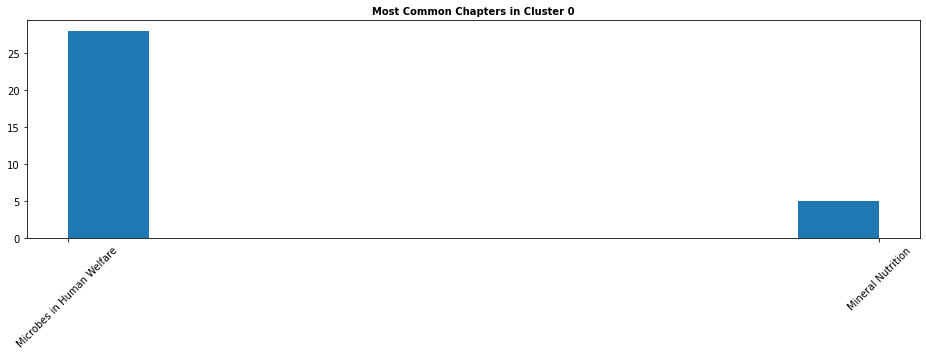

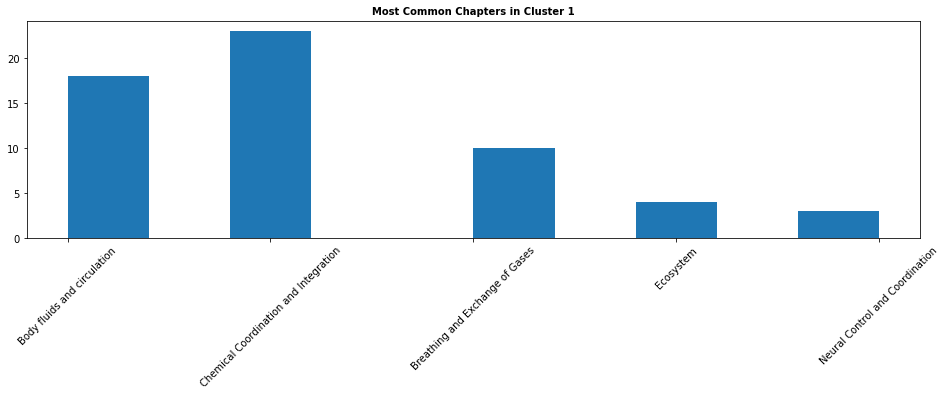

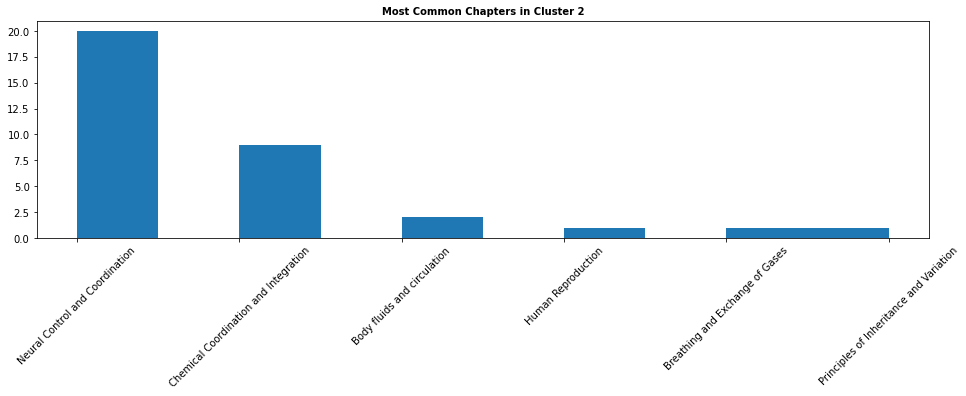

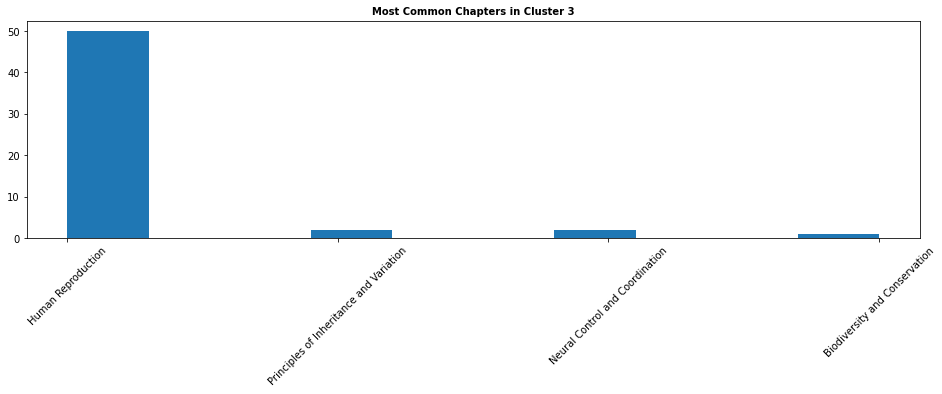

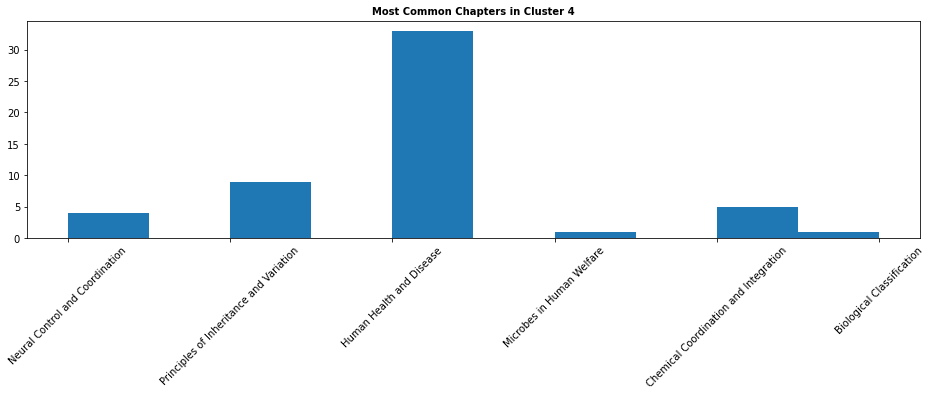

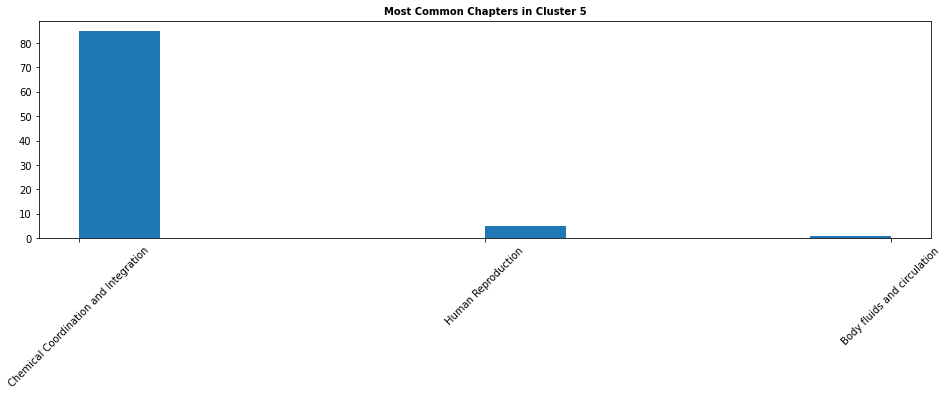

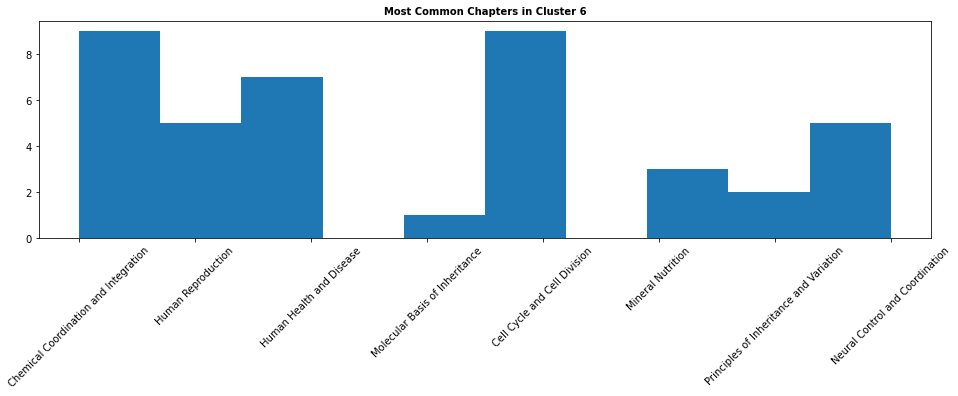

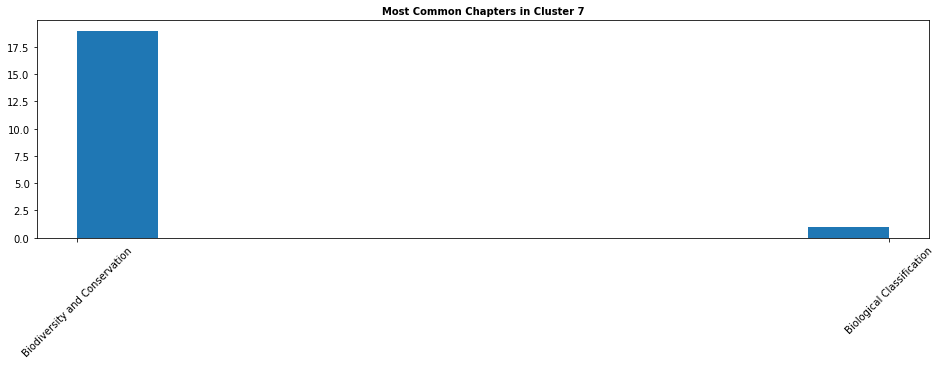

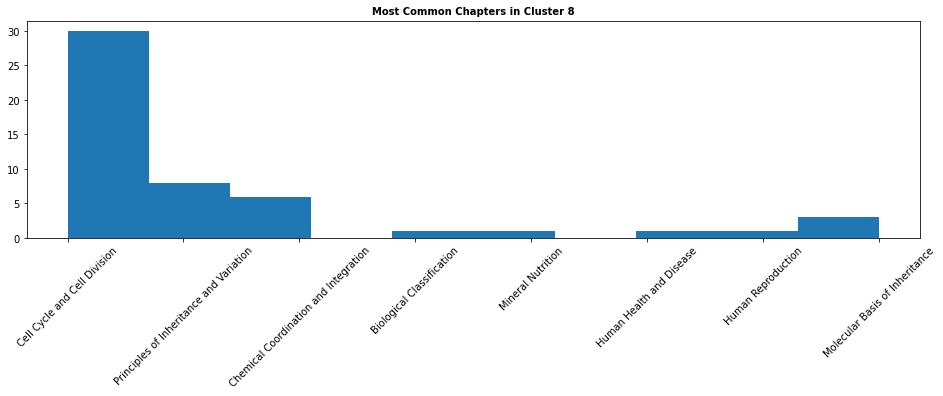

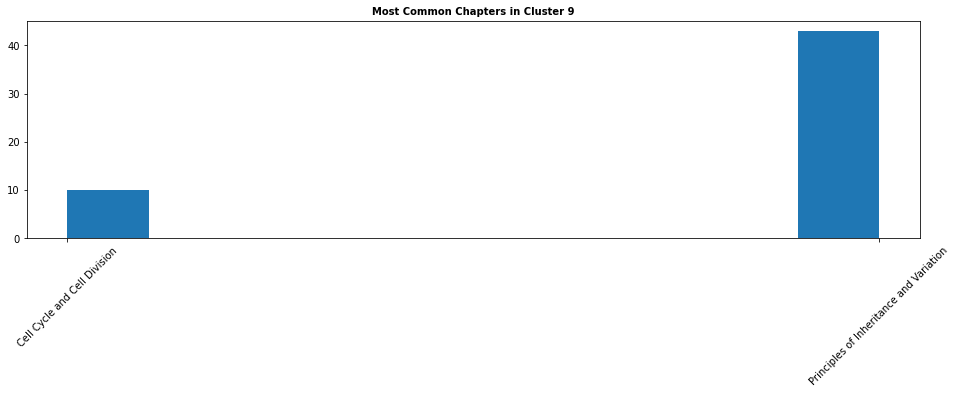

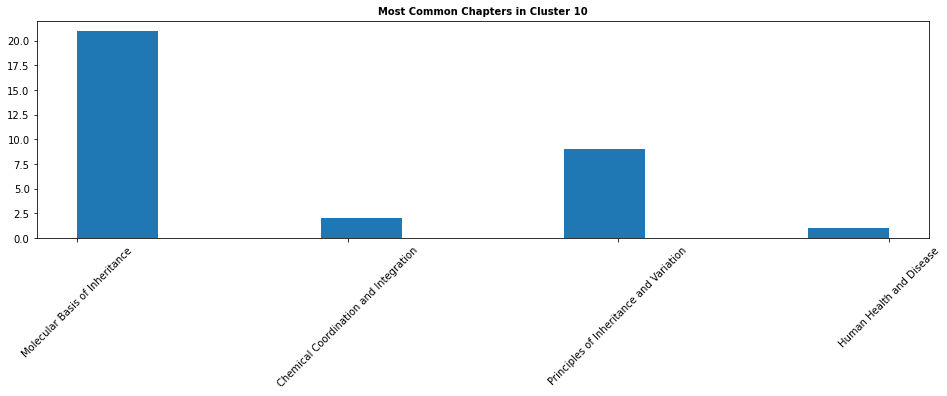

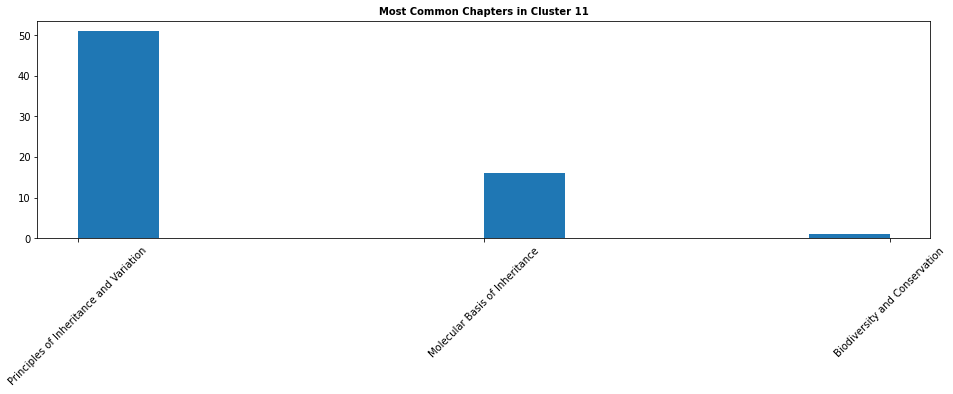

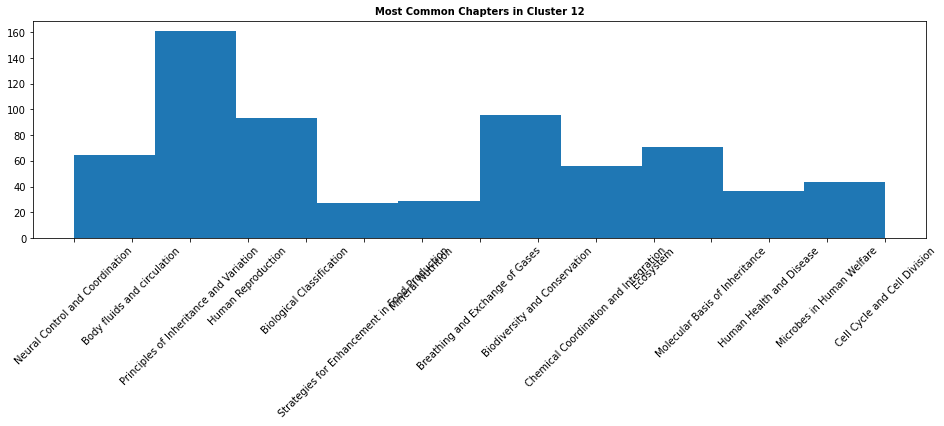

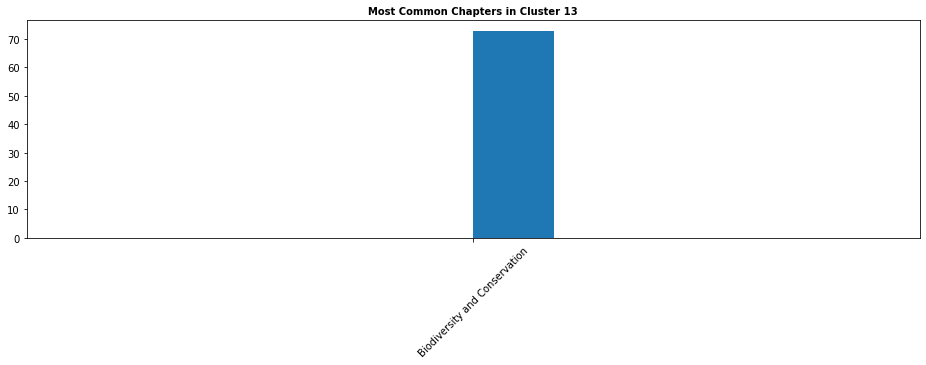

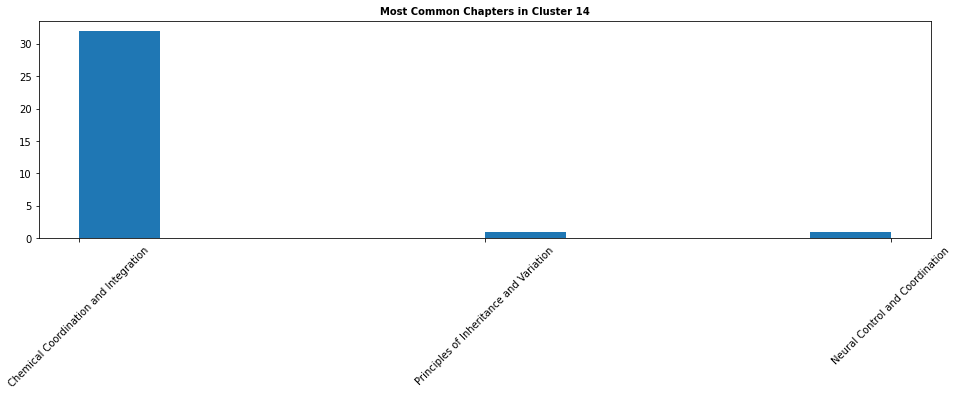

In [ ]:
cluster_label = []
for i in range(0,num_clusters):
    cluster_questions = example_data[example_data['label'] == i ]  #get all questions belonging to cluster i 
    cluster_chapters_list = cluster_questions['ChapterName'].tolist();
    plt.figure(figsize=(16,4))
    plt.hist(cluster_chapters_list)
    plt.xticks(rotation=45)
    cluster_label.append(max(set(cluster_chapters_list), key = cluster_chapters_list.count));
    plt.title(("Most Common Chapters in Cluster {}".format(i)), fontsize=10, fontweight='bold')

    

### We check how many questions are classified to each cluster 



In [ ]:
for i in range(0,num_clusters):
    print('No of Questions belonging to cluster ', i ,'are ',sum(example_data['label'] == i))

No of Questions belonging to cluster  0 are  33
No of Questions belonging to cluster  1 are  58
No of Questions belonging to cluster  2 are  34
No of Questions belonging to cluster  3 are  55
No of Questions belonging to cluster  4 are  53
No of Questions belonging to cluster  5 are  91
No of Questions belonging to cluster  6 are  41
No of Questions belonging to cluster  7 are  20
No of Questions belonging to cluster  8 are  51
No of Questions belonging to cluster  9 are  53
No of Questions belonging to cluster  10 are  33
No of Questions belonging to cluster  11 are  68
No of Questions belonging to cluster  12 are  679
No of Questions belonging to cluster  13 are  73
No of Questions belonging to cluster  14 are  34


In [ ]:
cluster_label[11] # cluster 11 has a very large number of questions in it. 
                #This is beacause Principles of Inheritance and Variation has highest contribution in example data 

'Principles of Inheritance and Variation'

### We now check how many chapter can we cover by using the above method. It is seen that we can only cover 9 chapters out ot 15

In [ ]:
# printing chapter that could be classified 
classified_chapters_clusters = np.unique(np.array(cluster_label)).tolist();
print(classified_chapters_clusters, len(classified_chapters_clusters))


['Biodiversity and Conservation', 'Cell Cycle and Cell Division', 'Chemical Coordination and Integration', 'Human Health and Disease', 'Human Reproduction', 'Microbes in Human Welfare', 'Molecular Basis of Inheritance', 'Neural Control and Coordination', 'Principles of Inheritance and Variation'] 9


In [ ]:
example_data.ChapterName.unique().tolist()

['Body fluids and circulation',
 'Neural Control and Coordination',
 'Chemical Coordination and Integration',
 'Biodiversity and Conservation',
 'Principles of Inheritance and Variation',
 'Human Reproduction',
 'Biological Classification',
 'Molecular Basis of Inheritance',
 'Cell Cycle and Cell Division',
 'Microbes in Human Welfare',
 'Strategies for Enhancement in Food Production',
 'Mineral Nutrition',
 'Breathing and Exchange of Gases',
 'Ecosystem',
 'Human Health and Disease']

### Our algorithm classifies data into 15 clusters which major represent 8 out of 15 chapters taken in example data. We see how was the propotion of this chapters in our example data 

In [ ]:
classfied_chapters_df= example_data[example_data['ChapterName'].isin(classified_chapters_clusters)]
classfied_chapters_df = classfied_chapters_df.groupby('ChapterName').count()
classfied_chapters_df
# printing propotion of chapter data in our original dataset 

,index,CourseName,SubjectName,TopicName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex,label
ChapterName,,,,,,,,,,
Biodiversity and Conservation,160,160,160,160,160,160,5,160,160,160
Cell Cycle and Cell Division,64,64,64,64,64,64,7,64,64,64
Chemical Coordination and Integration,227,227,227,227,227,227,8,227,227,227
Human Health and Disease,79,79,79,79,79,79,2,79,79,79
Human Reproduction,124,124,124,124,124,124,2,124,124,124
Microbes in Human Welfare,58,58,58,58,58,58,2,58,58,58
Molecular Basis of Inheritance,66,66,66,66,66,66,5,66,66,66
Neural Control and Coordination,84,84,84,84,84,84,2,84,84,84
Principles of Inheritance and Variation,287,287,287,287,287,287,12,287,287,287


### We can see that only those chapters which have >60 questions in examples data have only been able to be classified by our algorithm 

### We now look at the propotion of chapters which could not be represented in our classification

In [ ]:
unclassfied_chapters_df= example_data[[not elem for elem in 
                                           example_data['ChapterName'].isin(classified_chapters_clusters).tolist()]]
unclassfied_chapters_df=  unclassfied_chapters_df.groupby('ChapterName').count()
unclassfied_chapters_df
# propotion of chapter which could not be classified 

,index,CourseName,SubjectName,TopicName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex,label
ChapterName,,,,,,,,,,
Biological Classification,34,34,34,34,34,34,4,34,34,34
Body fluids and circulation,37,37,37,37,37,37,1,37,37,37
Breathing and Exchange of Gases,41,41,41,41,41,41,5,41,41,41
Ecosystem,50,50,50,50,50,50,4,50,50,50
Mineral Nutrition,38,38,38,38,38,38,3,38,38,38
Strategies for Enhancement in Food Production,27,27,27,27,27,27,1,27,27,27


### We can see that topics not classified by this algorithm has <60 questions, this means that we need more questions from these topics to classify them correctly 

### Testing the accuracy of this classification on test data 

### We will only use test data from the 8 chapters that we are able to classify correctly and see how accurate our classification is in assigning topics to these questions 

In [ ]:
trial_data
vectorized_trial_data= vectorized_trial_data[trial_data['ChapterName'].isin(classified_chapters_clusters).tolist()]; # taking only test data for which we have clusters 
trial_data_filtered = trial_data[trial_data['ChapterName'].isin(classified_chapters_clusters)]
vectorized_trial_data


,aaatac,aabb,aabbcc,aabbccthe,aac,aadenohypophysis,aag,ab,abcd,abcdefg,abdominal,abedcfg,aberration,aberrations,abgh,abh,ability,abiotic,able,abnormal,abnormalities,abnormality,abo,aboblood,aboutfifteen,abrupt,absence,absent,absorb,absorbed,absorbing,absorbthe,absorption,abundance,abundant,acc,accelerated,accessory,accommodation,accomplished,...,xrays,xxxx,xxxy,xxy,xyy,yawning,ybearing,ychromosome,year,yearround,years,yeast,yeastwhich,yellow,yellowish,ylinked,yoghurt,yolk,york,you,young,zea,zensen,zero,zgene,zinc,zona,zone,zones,zoo,zoocoenosis,zoological,zoology,zoos,zoosc,zoster,zsi,zygote,zygotes,zygotic
1376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predicted_cluster_labels = kmeans_result.predict(vectorized_trial_data) # making predictions from test data 

In [ ]:
trial_data_filtered_prediction.ChapterName.unique()

array(['Human Health and Disease', 'Biodiversity and Conservation',
       'Microbes in Human Welfare',
       'Principles of Inheritance and Variation',
       'Chemical Coordination and Integration',
       'Neural Control and Coordination', 'Cell Cycle and Cell Division',
       'Molecular Basis of Inheritance', 'Human Reproduction'],
      dtype=object)

### We see what chapter the clustering algorithm predicts for us using the test data 

In [ ]:
trial_data_filtered_prediction = trial_data_filtered
trial_data_filtered_prediction['label']=predicted_cluster_labels
trial_data_filtered_prediction['predicted_chapter']=[cluster_label[label] for label in 
                                                     trial_data_filtered_prediction['label'].tolist()]
    
                                                                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
trial_data_filtered_prediction

,index,CourseName,SubjectName,TopicName,ChapterName,KSCText,QuestionId,imageHTML,UseAs,Q_Latex,label,predicted_chapter
3,3,7/8 CBSE,Biology,Biology in Human Welfare,Human Health and Disease,Kwashiorkor,35703,NaN,Trial,Kwashiorkor disease is due to deficiency of :\...,4,Human Health and Disease
9,9,7/8 CBSE,Biology,Ecology,Biodiversity and Conservation,In situ (on site) Conservation,55588,NaN,Trial,Which of the following is a bird sanctuary?\n(...,12,Principles of Inheritance and Variation
13,13,7/8 CBSE,Biology,Biology in Human Welfare,Microbes in Human Welfare,Bacteria: Role in Agriculture and Industry,78612,NaN,Trial,Which of the following bacteria is are present...,0,Microbes in Human Welfare
28,28,7/8 CBSE,Biology,Biology in Human Welfare,Microbes in Human Welfare,Bacteria: Role in Agriculture and Industry,185929,NaN,Trial,An example of endomycorrhiza is \( \quad \) [N...,0,Microbes in Human Welfare
33,33,7/8 CBSE,Biology,Biology in Human Welfare,Microbes in Human Welfare,Bacteria: Role in Agriculture and Industry,78582,NaN,Trial,Role of de-nitrifying bacteria is to:\n(A) Bre...,12,Principles of Inheritance and Variation
...,...,...,...,...,...,...,...,...,...,...,...,...
1883,1883,7/8 CBSE,Biology,Human Physiology,Chemical Coordination and Integration,Endocrine Glands and their Roles - 1,57865,NaN,Trial,The posterior pituitary stores and releases:\n...,5,Chemical Coordination and Integration
1884,1884,7/8 CBSE,Biology,Human Physiology,Chemical Coordination and Integration,Endocrine Glands and Their Roles - 2,57828,NaN,Trial,Why insulin not given orally but injected into...,5,Chemical Coordination and Integration
1885,1885,7/8 CBSE,Biology,Ecology,Biodiversity and Conservation,Hot spots,60941,NaN,Trial,What are the total number of hot spots present...,12,Principles of Inheritance and Variation
1892,1892,7/8 CBSE,Biology,Cell Structure and Function,Cell Cycle and Cell Division,Bipolar Mitotic Spindle,139746,NaN,Trial,During the metaphase stage of mitosis spindle ...,12,Principles of Inheritance and Variation


In [ ]:
correct_predictions = trial_data_filtered_prediction[trial_data_filtered_prediction[
    'ChapterName']==trial_data_filtered_prediction['predicted_chapter']]

In [ ]:
test_acctracy = correct_predictions.shape[0]/trial_data_filtered_prediction.shape[0]  # calculating accuacy 
print('Accuracy for classfing test data is', test_acctracy* 100)

Accuracy for classfing test data is 56.074766355140184


### Most of the incorrect predictions are into the chapter Principles of Inheritance and Variation. This may be because it forms a huge chunk of our example data

In [ ]:
incorrect_predictions = trial_data_filtered_prediction[trial_data_filtered_prediction
                                            ['ChapterName']!=trial_data_filtered_prediction['predicted_chapter']]
print('Number of incorrect predictions',incorrect_predictions.shape[0]);
print('Incorrect Predictions to Principles of Inheritance and Variation-',
      sum(incorrect_predictions['predicted_chapter']=='Principles of Inheritance and Variation'))

Number of incorrect predictions 141
Incorrect Predictions to Principles of Inheritance and Variation- 124


## Using Deep learning techniques




### doing preprocessing

In [ ]:
trial_data,example_data = example_trial_split(bio_data)  # splitting into trial and example data 

label_name= 'ChapterName'; # label name is the column used for prediction


merged_test_train_data= preProcessDeepLearning(example_data,trial_data,label_name) 
# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 

uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']] # defining chapter_mappings beween chapterName and chapter label

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)

chapter_mapping

NameError: ignored

Preparing dataset for model




In [ ]:
train_x,train_y, test_x, test_y = train_test_split(corpus) # split data into test and train 
# do some custom pre processing
print(train_x[4])
train_x= preProcess(train_x)  # pre processing train data 
test_x  = preProcess(test_x)  # pre processing test data 
train_x[4]


### Testing different kernel sizes for our model by looping over different activation and kernel sizes, we take the one giving best accuracy 

In [ ]:
# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['relu', 'tanh']
filters = 100
kernel_sizes = [1, 2, 3, 4, 5, 6]

columns = ['Activation', 'Filters', 'Acc']
record = pd.DataFrame(columns = columns)


for activation in activations:

    for kernel_size in kernel_sizes:

        # encode data using
        # Cleaning and Tokenization
        tokenizer = Tokenizer(oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)

        # Turn the text into sequence
        training_sequences = tokenizer.texts_to_sequences(train_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)

        max_len = max_length(training_sequences)

        # Pad the sequence to have the same size
        Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

        word_index = tokenizer.word_index
        vocab_size = len(word_index)+1

        # Define the input shape
        model = define_model_cnn(filters, kernel_size, activation, input_dim=vocab_size, len_max=max_len, no_labels = no_labels)
         # Train the model
        model.fit(Xtrain, train_y, batch_size=50, epochs=60, verbose=2, callbacks=[callbacks], validation_data=(Xtest, test_y))

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        parameters = [activation, kernel_size]
        entries = parameters + [acc]

        temp = pd.DataFrame([entries], columns=columns)
        record = record.append(temp, ignore_index=True)
        print()
        print(record)
        print()

Epoch 1/60
31/31 - 5s - loss: 3.1920 - accuracy: 0.0653 - val_loss: 3.0608 - val_accuracy: 0.1460 - 5s/epoch - 159ms/step
Epoch 2/60
31/31 - 3s - loss: 3.0546 - accuracy: 0.1430 - val_loss: 2.9121 - val_accuracy: 0.2336 - 3s/epoch - 82ms/step
Epoch 3/60


In [ ]:
record.sort_values(by='Acc', ascending=False)
# sorting models according to their accuracy on bio dataset 

,Activation,Filters,Acc
6,tanh,1,0.826667
11,tanh,6,0.813333
9,tanh,4,0.810667
8,tanh,3,0.805333
7,tanh,2,0.802667
...,...,...,...
1,relu,2,0.754667
0,relu,1,0.704000
4,relu,5,0.693333
5,relu,6,0.677333


### why tanh gives better accuracy in prediction(output) layer

### we obeserve that tanh activation with kernel size = 1 gives us the best accuracy among all models, so we use this in all future applications 

### Run model on bio data 

In [ ]:
model_bio_cnn=  run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x,test_y=test_y)

Epoch 1/60
31/31 - 4s - loss: 3.1563 - accuracy: 0.1134 - val_loss: 2.9927 - val_accuracy: 0.1436 - 4s/epoch - 120ms/step
Epoch 2/60
31/31 - 2s - loss: 2.9975 - accuracy: 0.1608 - val_loss: 2.8458 - val_accuracy: 0.1752 - 2s/epoch - 76ms/step
Epoch 3/60
31/31 - 2s - loss: 2.8068 - accuracy: 0.2604 - val_loss: 2.6166 - val_accuracy: 0.3917 - 2s/epoch - 78ms/step
Epoch 4/60
31/31 - 2s - loss: 2.3831 - accuracy: 0.3968 - val_loss: 2.2416 - val_accuracy: 0.4696 - 2s/epoch - 75ms/step
Epoch 5/60
31/31 - 2s - loss: 2.0476 - accuracy: 0.4502 - val_loss: 2.0000 - val_accuracy: 0.4939 - 2s/epoch - 74ms/step
Epoch 6/60
31/31 - 2s - loss: 1.8354 - accuracy: 0.4964 - val_loss: 1.8370 - val_accuracy: 0.5231 - 2s/epoch - 71ms/step
Epoch 7/60
31/31 - 2s - loss: 1.6800 - accuracy: 0.5425 - val_loss: 1.7368 - val_accuracy: 0.5474 - 2s/epoch - 74ms/step
Epoch 8/60
31/31 - 2s - loss: 1.5858 - accuracy: 0.5491 - val_loss: 1.6685 - val_accuracy: 0.5669 - 2s/epoch - 76ms/step
Epoch 9/60
31/31 - 2s - loss: 1

In [ ]:
model_bio_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 79, 300)           2613600   
                                                                 
 conv1d_12 (Conv1D)          (None, 79, 100)           30100     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 39, 100)          0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 3900)              0         
                                                                 
 dropout_24 (Dropout)        (None, 3900)              0         
                                                                 
 dense_24 (Dense)            (None, 10)                39010     
                                                     

### make pred

In [ ]:
predicted_df = make_pred(model_bio_cnn,test_x= test_x, corpus= corpus)
predicted_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,CorrectLabel
3,Kwashiorkor disease is due to deficiency of :\...,19,test,Human Health and Disease,Human Health and Disease
6,In Whittaker's five kingdom classification uni...,7,test,Biological Classification,Biological Classification
9,Which of the following is a bird sanctuary?\n(...,4,test,Biodiversity and Conservation,Biodiversity and Conservation
13,Which of the following bacteria is are present...,10,test,Microbes in Human Welfare,Microbes in Human Welfare
28,An example of endomycorrhiza is \( \quad \) [N...,10,test,Microbes in Human Welfare,Microbes in Human Welfare
...,...,...,...,...,...
1888,Largest heart is of\n(A) Giraffe\n(B) Elephant...,0,test,Body fluids and circulation,Body fluids and circulation
1889,Toxic effect of carbon monoxide is due to its ...,13,test,Breathing and Exchange of Gases,Breathing and Exchange of Gases
1892,During the metaphase stage of mitosis spindle ...,9,test,Cell Cycle and Cell Division,Cell Cycle and Cell Division
1904,Which one of the following is an example of X ...,5,test,Principles of Inheritance and Variation,Principles of Inheritance and Variation


In [ ]:
predicted_df[predicted_df['First_prediction'] != predicted_df['CorrectLabel']]

,sentence,label,split,First_prediction,CorrectLabel
30,Choose the wrong statement-\n(A) Respiratory p...,13,test,Neural Control and Coordination,Breathing and Exchange of Gases
40,"When the cell is placed in water, it takes wat...",12,test,Cell Cycle and Cell Division,Mineral Nutrition
48,"The enzyme, nitrogenase which is capable of ni...",12,test,Microbes in Human Welfare,Mineral Nutrition
63,The diagram shows four arthropods. How many of...,22,test,Human Health and Disease,Animal Kingdom
76,Vasoconstriction causes\n(A) Increase in heart...,0,test,Mineral Nutrition,Body fluids and circulation
...,...,...,...,...,...
1798,Development of animal by asexual reproduction ...,6,test,Biological Classification,Human Reproduction
1801,Direction : Each of these questions contains a...,25,test,Respiration in Plants,Photosynthesis in higher plants
1823,The process of yolk synthesis is called :-\n(A...,6,test,Biological Classification,Human Reproduction
1827,Regulator gene controls chemical synthesis (op...,8,test,Principles of Inheritance and Variation,Molecular Basis of Inheritance


### importing the phy and chm datasets 

In [ ]:
chm_data = pd.read_csv('data-chm.csv')
phy_data = pd.read_csv('data-phy.csv')
chm_data.rename(columns={'Q_LATEX':'Q_Latex'},inplace = True) # renaming columns according to convention 


### Analysis for CHM data 

In [ ]:
trial_data,example_data = example_trial_split(chm_data) # splitting into test and example data 
# exploring the example_data 
print('Number of topics covered by example data',(example_data['TopicName'].unique()).shape[0])
print('Number of Chapters covered by example data',(example_data['ChapterName'].unique()).shape[0])
print('Number of KSC covered by example data',(example_data['KSCText'].unique()).shape[0])
print('Questions lacking latex data ', sum(pd.isnull(example_data['Q_Latex'])) )


number of example data are 1500
number of trial data are 500
Number of topics covered by example data 7
Number of Chapters covered by example data 14
Number of KSC covered by example data 160
Questions lacking latex data  0


In [ ]:
label_name= 'ChapterName'; # label based on which we need to classify the data 
merged_test_train_data= preProcessDeepLearning(example_data,trial_data,label_name) # doing processing for deeep learning model 
# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
corpus ## This is final data to be used 

No of unique ChapterName are 14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,label,split
0,Answer the following questions briefy :\r\n(i)...,0,train
1,Write IUPAC name of the following compound: \(...,1,train
2,Why is a solution of potassium hydroxide used ...,2,train
3,Addition of HCl to propene in presence of pero...,3,train
5,"What are carbohydrates? [Board March, 2016]\r\...",0,train
...,...,...,...
1965,Consider the following sequence of reaction. T...,3,test
1972,How are propan-1-amine and propan-2-amine prep...,1,test
1981,Give simple chemical tests to distinguish betw...,4,test
1982,Lasaigne's test is not shown by diazonium salt...,5,test


In [ ]:
train_x,train_y, test_x, test_y = train_test_split(corpus)
# do some custom pre processing
train_x= preProcess(train_x)
test_x  = preProcess(test_x)
train_x[4]


length of test data is -  500
length of train data is -  1500


'carbohydrates board march write reaction preparation nylon'

In [ ]:
model_chm_cnn =  run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x, test_y = test_y)

Epoch 1/60
30/30 - 2s - loss: 2.4493 - accuracy: 0.2533 - val_loss: 2.2825 - val_accuracy: 0.3620 - 2s/epoch - 62ms/step
Epoch 2/60
30/30 - 1s - loss: 2.1629 - accuracy: 0.3667 - val_loss: 1.8824 - val_accuracy: 0.5080 - 1s/epoch - 37ms/step
Epoch 3/60
30/30 - 1s - loss: 1.7993 - accuracy: 0.4733 - val_loss: 1.5970 - val_accuracy: 0.5600 - 1s/epoch - 37ms/step
Epoch 4/60
30/30 - 1s - loss: 1.5718 - accuracy: 0.5460 - val_loss: 1.4422 - val_accuracy: 0.6000 - 1s/epoch - 37ms/step
Epoch 5/60
30/30 - 2s - loss: 1.3797 - accuracy: 0.6207 - val_loss: 1.2998 - val_accuracy: 0.6660 - 2s/epoch - 50ms/step
Epoch 6/60
30/30 - 2s - loss: 1.2157 - accuracy: 0.6733 - val_loss: 1.1721 - val_accuracy: 0.7040 - 2s/epoch - 51ms/step
Epoch 7/60
30/30 - 2s - loss: 1.1018 - accuracy: 0.7080 - val_loss: 1.0687 - val_accuracy: 0.7040 - 2s/epoch - 50ms/step
Epoch 8/60
30/30 - 2s - loss: 1.0055 - accuracy: 0.7260 - val_loss: 0.9653 - val_accuracy: 0.7440 - 2s/epoch - 52ms/step
Epoch 9/60
30/30 - 2s - loss: 0.

### Accuracy before custom pre processing - 72 %
### Accuracy of custom pre processed data - 80 %

In [ ]:
predicted_df = make_pred(model_chm_cnn,test_x= test_x, corpus= corpus) # making predictions 
predicted_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,CorrectLabel
4,Which of the following dissolves in ionic solv...,5,test,Basic Principles of Organic Chemistry,Basic Principles of Organic Chemistry
13,Camphor is often used in molecular mass determ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
18,Which of the followingis not represented by so...,6,test,Adsorption and Colloids,Adsorption and Colloids
19,Which of the following method is used for sol....,6,test,Adsorption and Colloids,Adsorption and Colloids
20,When a small amount of \( \mathrm{FeCl}_{3} \)...,6,test,Adsorption and Colloids,Adsorption and Colloids
...,...,...,...,...,...
1965,Consider the following sequence of reaction. T...,3,test,Alkenes,Alkenes
1972,How are propan-1-amine and propan-2-amine prep...,1,test,Amines,Amines
1981,Give simple chemical tests to distinguish betw...,4,test,"Alcohols, Phenols and Ethers","Alcohols, Phenols and Ethers"
1982,Lasaigne's test is not shown by diazonium salt...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry


In [ ]:
predicted_df[predicted_df['First_prediction'] != predicted_df['CorrectLabel']]  # anlyzing wrong predictions 

,sentence,label,split,First_prediction,CorrectLabel
13,Camphor is often used in molecular mass determ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
24,Alkaline hydrolysis of which among the followi...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
25,How are (a) 1-nitropropane and (b) 2-nitroprop...,1,test,"Aldehydes, Ketones and Carboxylic Acids",Amines
30,What are Esters? How is methyl propionate prep...,11,test,"Aldehydes, Ketones and Carboxylic Acids","Aldehydes, Ketones and Carboxylic acids"
47,How will you obtain the following: \( \quad[ \...,7,test,"Alcohols, Phenols and Ethers","Aldehydes, Ketones and Carboxylic Acids"
...,...,...,...,...,...
1818,Calculate the concentration of nitric acid in ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
1932,Will sodium cyanide give a positive Lassaigne'...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
1962,Where does the water present in the egg go aft...,0,test,Adsorption and Colloids,Biomolecules
1964,How is ethoxy ethane prepared by Williamson's ...,4,test,"Alcohol, Phenols and Ethers","Alcohols, Phenols and Ethers"


### Topics not correctly classified belong to very silimar other topics, some are even same with slight spelling differences, eg Alcohol, Phenols and Ethers	and Alcohols, Phenols and Ethers	

### Analysis for Phy data 

In [ ]:
phy_data.rename(columns={'Q_LATEX':'Q_Latex'},inplace = True)
trial_data,example_data = example_trial_split(phy_data)



# exploring the example_data 
print('Number of topics covered by example data',(example_data['TopicName'].unique()).shape[0])
print('Number of Chapters covered by example data',(example_data['ChapterName'].unique()).shape[0])
print('Number of KSC covered by example data',(example_data['KSCText'].unique()).shape[0])
print('Questions lacking latex data ', sum(pd.isnull(example_data['Q_Latex'])) )

number of example data are 836
number of trial data are 250
Number of topics covered by example data 6
Number of Chapters covered by example data 13
Number of KSC covered by example data 36
Questions lacking latex data  0


In [ ]:
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,'ChapterName')

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
corpus ## This is final data to be used 

No of unique ChapterName are 13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,label,split
0,"If \( \mathrm{P}, \mathrm{Q} \) and \( \mathrm...",0,train
1,An infinitely long current carrying wire and a...,1,train
3,A charged particle of specific charge \( \left...,1,train
4,"If C (velocity of light), h (Planck's constant...",0,train
6,The following configuration of gate is equival...,2,train
...,...,...,...
1054,Assertion : Electromagnets are made of soft ir...,1,test
1055,The correct graph which shows the variation of...,1,test
1063,Two wires \( \mathrm{W}_{1} \& \mathrm{~W}_{2}...,1,test
1079,A beam of electrons of energy E scatters from ...,5,test


In [ ]:
train_x,train_y, test_x, test_y = train_test_split(corpus)
# do some custom pre processing
train_x= preProcess(train_x)
test_x  = preProcess(test_x)
train_x[4]
train_x

length of test data is -  250
length of train data is -  836


'configuration gate equivalent nand xor'

In [ ]:
model_phy =  run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x, test_y = test_y)

Epoch 1/60
17/17 - 2s - loss: 2.3255 - accuracy: 0.3361 - val_loss: 2.1540 - val_accuracy: 0.3600 - 2s/epoch - 95ms/step
Epoch 2/60
17/17 - 1s - loss: 2.1490 - accuracy: 0.3732 - val_loss: 2.0799 - val_accuracy: 0.3600 - 855ms/epoch - 50ms/step
Epoch 3/60
17/17 - 1s - loss: 2.0014 - accuracy: 0.4139 - val_loss: 1.9014 - val_accuracy: 0.3760 - 844ms/epoch - 50ms/step
Epoch 4/60
17/17 - 1s - loss: 1.7773 - accuracy: 0.4761 - val_loss: 1.7157 - val_accuracy: 0.4360 - 839ms/epoch - 49ms/step
Epoch 5/60
17/17 - 1s - loss: 1.6067 - accuracy: 0.5371 - val_loss: 1.5912 - val_accuracy: 0.4800 - 849ms/epoch - 50ms/step
Epoch 6/60
17/17 - 1s - loss: 1.4681 - accuracy: 0.5646 - val_loss: 1.4850 - val_accuracy: 0.4720 - 1s/epoch - 62ms/step
Epoch 7/60
17/17 - 2s - loss: 1.4241 - accuracy: 0.5670 - val_loss: 1.4212 - val_accuracy: 0.5240 - 2s/epoch - 100ms/step
Epoch 8/60
17/17 - 2s - loss: 1.3045 - accuracy: 0.5969 - val_loss: 1.3633 - val_accuracy: 0.5160 - 2s/epoch - 99ms/step
Epoch 9/60
17/17 - 

In [ ]:
pred_df = make_pred(model_phy,test_x,corpus)

predicted_df[predicted_df['First_prediction'] != predicted_df['CorrectLabel']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,CorrectLabel
13,Camphor is often used in molecular mass determ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
24,Alkaline hydrolysis of which among the followi...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
25,How are (a) 1-nitropropane and (b) 2-nitroprop...,1,test,"Aldehydes, Ketones and Carboxylic Acids",Amines
30,What are Esters? How is methyl propionate prep...,11,test,"Aldehydes, Ketones and Carboxylic Acids","Aldehydes, Ketones and Carboxylic acids"
47,How will you obtain the following: \( \quad[ \...,7,test,"Alcohols, Phenols and Ethers","Aldehydes, Ketones and Carboxylic Acids"
...,...,...,...,...,...
1818,Calculate the concentration of nitric acid in ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
1932,Will sodium cyanide give a positive Lassaigne'...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
1962,Where does the water present in the egg go aft...,0,test,Adsorption and Colloids,Biomolecules
1964,How is ethoxy ethane prepared by Williamson's ...,4,test,"Alcohol, Phenols and Ethers","Alcohols, Phenols and Ethers"


### Validation accuracy is stuck at 36 % with sigmoid filter, accuracy around 60% with tanh 
### Accuracy for physcs chapter is less than other subject whereas KSC accuracy is higher. This can be due to small dataset and very similar chapter/KSC level data 

### Doing analysis for total dataset 

### Predicting Chapter

In [ ]:
total_data= pd.read_csv('total_data.csv')
total_data.rename(columns={'Q_LATEX':'Q_Latex'},inplace = True)
trial_data, example_data = example_trial_split(total_data)



# exploring the example_data 
print('Number of topics covered by example data',(example_data['TopicName'].unique()).shape[0])
print('Number of Chapters covered by example data',(example_data['ChapterName'].unique()).shape[0])
print('Number of KSC covered by example data',(example_data['KSCText'].unique()).shape[0])
print('Questions lacking latex data ', sum(pd.isnull(example_data['Q_Latex'])) )


number of example data are 5353
number of trial data are 1661
Number of topics covered by example data 27
Number of Chapters covered by example data 64
Number of KSC covered by example data 527
Questions lacking latex data  0


In [ ]:
label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
corpus ## This is final data to be used 

No of unique ChapterName are 64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,label,split
0,Removal of which organ will have least effect ...,0,train
1,Our ear can hear sound waves of the frequency ...,1,train
2,"Temperature inversions, heat islands, and dust...",2,train
4,First heart transplant was performed by\n(A) W...,0,train
5,"Which gland prepare you for flight, fear and f...",3,train
...,...,...,...
6997,The area of the parallelogram ABCD is \( 90 \m...,57,test
6999,An umbrella is made by stitching 10 triangular...,58,test
7000,Name the angles in the given figure.,54,test
7007,(a) Identify three triangles in the figure.\n(...,54,test


In [ ]:
train_x,train_y, test_x, test_y = train_test_split(corpus)
train_x= preProcess(train_x)
test_x  = preProcess(test_x)


length of test data is -  1661
length of train data is -  5353


In [ ]:
model_total_chapter = run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x,test_y = test_y)


Epoch 1/60
108/108 - 9s - loss: 3.8891 - accuracy: 0.0912 - val_loss: 3.5596 - val_accuracy: 0.2360 - 9s/epoch - 82ms/step
Epoch 2/60
108/108 - 7s - loss: 3.4119 - accuracy: 0.2253 - val_loss: 3.0313 - val_accuracy: 0.2920 - 7s/epoch - 63ms/step
Epoch 3/60
108/108 - 6s - loss: 2.9158 - accuracy: 0.3135 - val_loss: 2.6203 - val_accuracy: 0.4636 - 6s/epoch - 59ms/step
Epoch 4/60
108/108 - 7s - loss: 2.5597 - accuracy: 0.3916 - val_loss: 2.2999 - val_accuracy: 0.5358 - 7s/epoch - 69ms/step
Epoch 5/60
108/108 - 6s - loss: 2.3268 - accuracy: 0.4371 - val_loss: 2.0661 - val_accuracy: 0.5593 - 6s/epoch - 58ms/step
Epoch 6/60
108/108 - 6s - loss: 2.1163 - accuracy: 0.4741 - val_loss: 1.8856 - val_accuracy: 0.5984 - 6s/epoch - 58ms/step
Epoch 7/60
108/108 - 6s - loss: 1.9740 - accuracy: 0.4986 - val_loss: 1.7366 - val_accuracy: 0.6490 - 6s/epoch - 59ms/step
Epoch 8/60
108/108 - 6s - loss: 1.8546 - accuracy: 0.5268 - val_loss: 1.6339 - val_accuracy: 0.6665 - 6s/epoch - 58ms/step
Epoch 9/60
108/1

KeyboardInterrupt: ignored

In [ ]:
chapter_model = model
predictions= model.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['Chapter_code'].tolist()
correct_labels = [chapter_mapping[chapter_mapping['Chapter_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [chapter_mapping[chapter_mapping['Chapter_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

['Human Health and Disease',
 'Biological Classification',
 'Biodiversity and Conservation',
 'Microbes in Human Welfare',
 'Microbes in Human Welfare',
 'Aldehydes, Ketones and Carboxylic Acids',
 'Chemical Coordination and Integration',
 'Environmental Issues',
 'Projectile',
 'Principles of Inheritance and Variation']

In [ ]:
test_corpus['First_prediction'] = first_predicted_labels
test_corpus['ChapterName'] = correct_labels
test_corpus[test_corpus['First_prediction'] == test_corpus['ChapterName']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentence,label,split,Chapter_code,First_prediction,ChapterName
3,Kwashiorkor disease is due to deficiency of :\...,19,test,19,Human Health and Disease,Human Health and Disease
6,In Whittaker's five kingdom classification uni...,7,test,7,Biological Classification,Biological Classification
9,Which of the following is a bird sanctuary?\n(...,4,test,4,Biodiversity and Conservation,Biodiversity and Conservation
13,Which of the following bacteria is are present...,10,test,10,Microbes in Human Welfare,Microbes in Human Welfare
28,An example of endomycorrhiza is \( \quad \) [N...,10,test,10,Microbes in Human Welfare,Microbes in Human Welfare
...,...,...,...,...,...,...
1052,"Two gold pieces, each of mass \( 0.035 \mathrm...",41,test,41,"Unit, Vector and Dimension","Unit, Vector and Dimension"
1053,Why ferromagnetic substance are used to make p...,42,test,42,"Magnetism, Magnetic Effects of Current","Magnetism, Magnetic Effects of Current"
1054,Assertion : Electromagnets are made of soft ir...,42,test,42,"Magnetism, Magnetic Effects of Current","Magnetism, Magnetic Effects of Current"
1055,The correct graph which shows the variation of...,42,test,42,"Magnetism, Magnetic Effects of Current","Magnetism, Magnetic Effects of Current"


### Training on biology data for KSC 

In [ ]:
data_bio= pd.read_csv('data-bio.csv')
trial_data, example_data = example_trial_split(data_bio)

print('Number of topics covered by example data',(example_data['TopicName'].unique()).shape[0])
print('Number of Chapters covered by example data',(example_data['ChapterName'].unique()).shape[0])
print('Number of KSC covered by example data',(merged_test_train_data['KSCText'].unique()).shape[0])
print('Questions lacking latex data ', sum(pd.isnull(example_data['Q_Latex'])) )

label_name = 'KSCText'
merged_test_train_data= preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
KSC_mapping_bio= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
corpus ## This is final data to be used 

train_x,train_y, test_x, test_y = train_test_split(corpus)
# do some custom pre processing
train_x= preProcess(train_x)
test_x  = preProcess(test_x)


model_bio_KSC = run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x,test_y = test_y)


number of example data are 1517
number of trial data are 411
No of unique KSCText are 273
length of test data is -  411
length of train data is -  1517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Epoch 1/60
31/31 - 3s - loss: 5.5710 - accuracy: 0.0079 - val_loss: 5.5024 - val_accuracy: 0.0341 - 3s/epoch - 112ms/step
Epoch 2/60
31/31 - 2s - loss: 5.4470 - accuracy: 0.0250 - val_loss: 5.3757 - val_accuracy: 0.0341 - 2s/epoch - 71ms/step
Epoch 3/60
31/31 - 2s - loss: 5.3375 - accuracy: 0.0224 - val_loss: 5.2891 - val_accuracy: 0.0341 - 2s/epoch - 75ms/step
Epoch 4/60
31/31 - 2s - loss: 5.2508 - accuracy: 0.0270 - val_loss: 5.2344 - val_accuracy: 0.0341 - 2s/epoch - 73ms/step
Epoch 5/60
31/31 - 2s - loss: 5.1863 - accuracy: 0.0283 - val_loss: 5.1982 - val_accuracy: 0.0341 - 2s/epoch - 72ms/step
Epoch 6/60
31/31 - 2s - loss: 5.1409 - accuracy: 0.0310 - val_loss: 5.1680 - val_accuracy: 0.0341 - 2s/epoch - 71ms/step
Epoch 7/60
31/31 - 2s - loss: 5.1051 - accuracy: 0.0415 - val_loss: 5.1396 - val_accuracy: 0.0535 - 2s/epoch - 73ms/step
Epoch 8/60
31/31 - 2s - loss: 5.0442 - accuracy: 0.0389 - val_loss: 5.1130 - val_accuracy: 0.0608 - 2s/epoch - 72ms/step
Epoch 9/60
31/31 - 2s - loss: 4

### Some of the KSC around 20 are not even present in the example data 

### We have very low accuracy for KSC, this seems to be due to lack of KSC data in our dataset 

In [ ]:
### doing Topic  and subject classification 

total_data.rename(columns={'Q_LATEX':'Q_Latex'},inplace = True)
example_data = total_data[total_data.UseAs == 'Example']
print('number of example data are', example_data.shape[0])
trial_data = total_data[total_data.UseAs == 'Trial']
print('number of trial data are', trial_data.shape[0])


trial_data.to_csv('trial_data_total.csv')
example_data.to_csv('example_data_total.csv')


# exploring the example_data 
print('Number of topics covered by example data',(example_data['TopicName'].unique()).shape[0])
print('Number of Chapters covered by example data',(example_data['ChapterName'].unique()).shape[0])
print('Number of KSC covered by example data',(example_data['KSCText'].unique()).shape[0])
print('Questions lacking latex data ', sum(pd.isnull(example_data['Q_Latex'])) )

number of example data are 3853
number of trial data are 1161
Number of topics covered by example data 21
Number of Chapters covered by example data 54
Number of KSC covered by example data 455
Questions lacking latex data  0


In [ ]:
label_name = 'SubjectName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
corpus ## This is final data to be used 

No of unique SubjectName are 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,sentence,label,split
0,Removal of which organ will have least effect ...,0,train
1,Our ear can hear sound waves of the frequency ...,0,train
2,"Temperature inversions, heat islands, and dust...",0,train
4,First heart transplant was performed by\n(A) W...,0,train
5,"Which gland prepare you for flight, fear and f...",0,train
...,...,...,...
4982,Assertion : Electromagnets are made of soft ir...,2,test
4983,The correct graph which shows the variation of...,2,test
4991,Two wires \( \mathrm{W}_{1} \& \mathrm{~W}_{2}...,2,test
5007,A beam of electrons of energy E scatters from ...,2,test


In [ ]:
# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x = list(corpus[corpus.split=='train'].sentence)
train_y = np.array(corpus[corpus.split=='train'].label)
print(len(train_x))
print(len(train_y))

test_x = list(corpus[corpus.split=='test'].sentence)
test_y = np.array(corpus[corpus.split=='test'].label)

print('Text Before Pre processing - ',train_x[4])

train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[4])

print(len(test_x))
print(len(test_y))
print('Number of labels', no_labels)

3853
3853
Text Before Pre processing -  Which gland prepare you for flight, fear and fight during adverse condition-
(A) Parathyroid
(B) Thyroid
(C) Adrenals
(D) pituitary
Text After Pre processing -  gland prepare flight fear fight adverse condition parathyroid thyroid adrenals pituitary
1161
1161
Number of labels 3


In [ ]:
model_total_subject = run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x,train_test= train_test)


Epoch 1/60
78/78 - 6s - loss: 0.8889 - accuracy: 0.5962 - val_loss: 0.3700 - val_accuracy: 0.9363 - 6s/epoch - 77ms/step
Epoch 2/60
78/78 - 6s - loss: 0.1936 - accuracy: 0.9657 - val_loss: 0.0703 - val_accuracy: 0.9879 - 6s/epoch - 75ms/step
Epoch 3/60
78/78 - 5s - loss: 0.0837 - accuracy: 0.9886 - val_loss: 0.0416 - val_accuracy: 0.9897 - 5s/epoch - 70ms/step
Epoch 4/60
78/78 - 5s - loss: 0.0619 - accuracy: 0.9917 - val_loss: 0.0316 - val_accuracy: 0.9905 - 5s/epoch - 67ms/step
Epoch 5/60
78/78 - 5s - loss: 0.0507 - accuracy: 0.9907 - val_loss: 0.0285 - val_accuracy: 0.9922 - 5s/epoch - 63ms/step
Epoch 6/60
78/78 - 5s - loss: 0.0451 - accuracy: 0.9933 - val_loss: 0.0283 - val_accuracy: 0.9922 - 5s/epoch - 64ms/step
Epoch 7/60
78/78 - 6s - loss: 0.0444 - accuracy: 0.9896 - val_loss: 0.0233 - val_accuracy: 0.9940 - 6s/epoch - 72ms/step
Epoch 8/60
78/78 - 7s - loss: 0.0393 - accuracy: 0.9917 - val_loss: 0.0252 - val_accuracy: 0.9914 - 7s/epoch - 95ms/step
Epoch 9/60
78/78 - 9s - loss: 0.

In [ ]:
pred_df = make_pred(model_total_subject,test_x,corpus)
pred_df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,CorrectLabel
3,Kwashiorkor disease is due to deficiency of :\...,0,test,Biology,Biology
6,In Whittaker's five kingdom classification uni...,0,test,Biology,Biology
9,Which of the following is a bird sanctuary?\n(...,0,test,Biology,Biology
13,Which of the following bacteria is are present...,0,test,Biology,Biology
28,An example of endomycorrhiza is \( \quad \) [N...,0,test,Biology,Biology
...,...,...,...,...,...
4982,Assertion : Electromagnets are made of soft ir...,2,test,Physics,Physics
4983,The correct graph which shows the variation of...,2,test,Physics,Physics
4991,Two wires \( \mathrm{W}_{1} \& \mathrm{~W}_{2}...,2,test,Physics,Physics
5007,A beam of electrons of energy E scatters from ...,2,test,Physics,Physics


### We are able to get an accuracy of >99% for predicting the subject 

### Doing predictions for Topics now 

In [ ]:
### doing Topic  and subject classification 
label_name = 'TopicName'

merged_test_train_data =merged_test_train_data[['Q_Latex',label_name,'split']]
merged_test_train_data.rename(columns = {'Q_Latex':'sentence',	'TopicName':'label'}, inplace = True)
uniq_chapte_list = merged_test_train_data['label'].unique().tolist()
merged_test_train_data['Topic_code'] = [uniq_chapte_list.index(chapterName) for chapterName in merged_test_train_data['label'].tolist()] 

corpus= merged_test_train_data
topic_mapping= corpus[['label','Topic_code']]
corpus['label'] = corpus['Topic_code']
no_labels = len(corpus['label'].unique().tolist())
corpus

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,sentence,label,split,Topic_code
0,Removal of which organ will have least effect ...,0,train,0
1,Our ear can hear sound waves of the frequency ...,0,train,0
2,"Temperature inversions, heat islands, and dust...",1,train,1
4,First heart transplant was performed by\n(A) W...,0,train,0
5,"Which gland prepare you for flight, fear and f...",0,train,0
...,...,...,...,...
1054,Assertion : Electromagnets are made of soft ir...,16,test,16
1055,The correct graph which shows the variation of...,16,test,16
1063,Two wires \( \mathrm{W}_{1} \& \mathrm{~W}_{2}...,16,test,16
1079,A beam of electrons of energy E scatters from ...,19,test,19


In [ ]:
# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x = list(corpus[corpus.split=='train'].sentence)
train_y = np.array(corpus[corpus.split=='train'].label)
print(len(train_x))
print(len(train_y))

test_x = list(corpus[corpus.split=='test'].sentence)
test_y = np.array(corpus[corpus.split=='test'].label)

print('Text Before Pre processing - ',train_x[4])

train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[4])

print(len(test_x))
print(len(test_y))
print('Number of labels', no_labels)

3853
3853
Text Before Pre processing -  Which gland prepare you for flight, fear and fight during adverse condition-
(A) Parathyroid
(B) Thyroid
(C) Adrenals
(D) pituitary
Text After Pre processing -  gland prepare flight fear fight adverse condition parathyroid thyroid adrenals pituitary
1161
1161
Number of labels 21


In [ ]:
model_total_topic = run_cnn_model(no_labels= no_labels, activation= 'tanh', kernel_size = 1,train_x=train_x ,test_x= test_x,train_test= train_test)


Epoch 1/60
78/78 - 10s - loss: 2.9263 - accuracy: 0.0968 - val_loss: 2.7688 - val_accuracy: 0.1128 - 10s/epoch - 125ms/step
Epoch 2/60
78/78 - 9s - loss: 2.5469 - accuracy: 0.1791 - val_loss: 2.0722 - val_accuracy: 0.3471 - 9s/epoch - 115ms/step
Epoch 3/60
78/78 - 9s - loss: 2.1409 - accuracy: 0.2728 - val_loss: 1.7625 - val_accuracy: 0.3609 - 9s/epoch - 114ms/step
Epoch 4/60
78/78 - 9s - loss: 1.9303 - accuracy: 0.3169 - val_loss: 1.6343 - val_accuracy: 0.4074 - 9s/epoch - 114ms/step
Epoch 5/60
78/78 - 9s - loss: 1.8386 - accuracy: 0.3514 - val_loss: 1.5253 - val_accuracy: 0.4358 - 9s/epoch - 115ms/step
Epoch 6/60
78/78 - 9s - loss: 1.7791 - accuracy: 0.3545 - val_loss: 1.4624 - val_accuracy: 0.4892 - 9s/epoch - 114ms/step
Epoch 7/60
78/78 - 9s - loss: 1.7060 - accuracy: 0.3810 - val_loss: 1.3860 - val_accuracy: 0.5177 - 9s/epoch - 113ms/step
Epoch 8/60
78/78 - 9s - loss: 1.6874 - accuracy: 0.3735 - val_loss: 1.3253 - val_accuracy: 0.5185 - 9s/epoch - 114ms/step
Epoch 9/60
78/78 - 9s 

In [ ]:
pred_df = make_pred(model_total_subject,test_x,corpus)
pred_df


## Using a 2 layer NN for prediction 

In [50]:
model_NN = simple_NN_model();
model_NN.summary() # summary of our 1 layer NN model 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 11,110
Trainable params: 11,110
Non-trainable params: 0
_________________________________________________________________


### Analysis for total dataset

In [54]:
# load total dataset 
total_data = pd.read_csv('total_data.csv')
trial_data, example_data = example_trial_split(total_data)

label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x,train_y, test_x, test_y = train_test_split(corpus)


train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])


tokenizer_total = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_total.texts_to_matrix(train_x, mode='freq')  # tokenize data 
Xtest = tokenizer_total.texts_to_matrix(test_x, mode='freq')

model_chapter_total = simple_NN_model(no_labels,len(Xtest[0])) # initialize model 
# set training parameters 
batch_size = 50
epochs = 60
verbose =2
# compile model 
model_chapter_total.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# fit model 
model_chapter_total.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))

# get loass and accuracy for the trained model 
loss, acc = model_chapter_total.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))

predictions= model_chapter_total.predict(Xtest,verbose= 0 )  # make predictions from the model 
first_predictions= np.argmax(predictions,axis= 1).tolist()  # get best prediction

test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [chapter_mapping[chapter_mapping['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [chapter_mapping[chapter_mapping['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
incorrect_chapter_pred = test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]
incorrect_chapter_pred

number of example data are 5353
number of trial data are 1661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique ChapterName are 64
length of test data is -  1661
length of train data is -  5353
Text After Pre processing -  first heart transplant performed william harvey watson christian bernard khorana
Epoch 1/60
108/108 - 2s - loss: 3.8976 - accuracy: 0.1818 - val_loss: 3.4394 - val_accuracy: 0.1710 - 2s/epoch - 21ms/step
Epoch 2/60
108/108 - 1s - loss: 3.2560 - accuracy: 0.2107 - val_loss: 3.0006 - val_accuracy: 0.2763 - 1s/epoch - 13ms/step
Epoch 3/60
108/108 - 1s - loss: 2.8643 - accuracy: 0.3497 - val_loss: 2.6010 - val_accuracy: 0.4413 - 1s/epoch - 13ms/step
Epoch 4/60
108/108 - 1s - loss: 2.4731 - accuracy: 0.4801 - val_loss: 2.2364 - val_accuracy: 0.5671 - 1s/epoch - 13ms/step
Epoch 5/60
108/108 - 1s - loss: 2.1292 - accuracy: 0.5591 - val_loss: 1.9394 - val_accuracy: 0.6081 - 1s/epoch - 12ms/step
Epoch 6/60
108/108 - 1s - loss: 1.8466 - accuracy: 0.6051 - val_loss: 1.7024 - val_accuracy: 0.6388 - 1s/epoch - 13ms/step
Epoch 7/60
108/108 - 1s - loss: 1.6236 - accuracy: 0.6426

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
3,Kwashiorkor disease is due to deficiency of :\...,19,test,Chemical Coordination and Integration,Human Health and Disease
30,Choose the wrong statement-\n(A) Respiratory p...,13,test,Mineral Nutrition,Breathing and Exchange of Gases
40,"When the cell is placed in water, it takes wat...",12,test,Transport in Plants,Mineral Nutrition
48,"The enzyme, nitrogenase which is capable of ni...",12,test,Microbes in Human Welfare,Mineral Nutrition
63,The diagram shows four arthropods. How many of...,22,test,Microbes in Human Welfare,Animal Kingdom
...,...,...,...,...,...
6904,The side of a regular hexagon (See figure) is ...,62,test,Area Perimeter of 2D shapes,Algebra
6918,Assertion: The area of a trapezium whose paral...,57,test,Area Perimeter of 2D shapes,Area of Parallelograms and Triangle
6919,"In the adjoining figure, \( A B C D \) is a tr...",57,test,Area Perimeter of 2D shapes,Area of Parallelograms and Triangle
6999,An umbrella is made by stitching 10 triangular...,58,test,Areas Related to Circles,Area Perimeter of 2D shapes


### This model gives us a better accuracy of 80%, which is 2% better than without math data 

In [55]:
print('Top misclassified labels')
incorrect_chapter_pred.groupby('labelName').count().sort_values(by = 'sentence', ascending = False).head(10).sentence

Top misclassified labels


labelName
Magnetic Materials                                      31
Magnetism                                               31
Basic Principles of Organic Chemistry                   30
Basic principles and techniques in Organic Chemistry    26
Magnetism, Magnetic Effects of Current                  25
Area of Parallelograms and Triangle                     21
 Area Perimeter of 2D shapes                            18
Human Reproduction                                      10
Alcohol, Phenols and Ethers                              8
Aldehydes, Ketones and Carboxylic Acids                  6
Name: sentence, dtype: int64

### using NN to predict KSC

In [ ]:
label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
KSC_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)


## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x,train_y, test_x, test_y = train_test_split(corpus)

train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])

no_labels = len(corpus['label'].unique().tolist())
print('No of KSC are',no_labels)


tokenizer_total = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_total.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_total.texts_to_matrix(test_x, mode='freq')


# running model and doing predictions 
model_KSC_total = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_KSC_total.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_KSC_total.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))
loss, acc = model_KSC_total.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))





predictions= model_KSC_total.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [KSC_mapping[KSC_mapping['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [KSC_mapping[KSC_mapping['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
incorrect_ksc_pred = test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]
print('Top misclassified  KSC labels')
incorrect_ksc_pred.groupby('labelName').count().sort_values(by = 'sentence', ascending = False).head(10).sentence


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique KSCText are 546
length of test data is -  1661
length of train data is -  5353
Text After Pre processing -  first heart transplant performed william harvey watson christian bernard khorana
No of KSC are 546
Epoch 1/60
108/108 - 2s - loss: 6.1392 - accuracy: 0.0284 - val_loss: 5.7700 - val_accuracy: 0.0271 - 2s/epoch - 18ms/step
Epoch 2/60
108/108 - 2s - loss: 5.5729 - accuracy: 0.0226 - val_loss: 5.5389 - val_accuracy: 0.0157 - 2s/epoch - 14ms/step
Epoch 3/60
108/108 - 1s - loss: 5.4322 - accuracy: 0.0269 - val_loss: 5.4459 - val_accuracy: 0.0518 - 1s/epoch - 13ms/step
Epoch 4/60
108/108 - 1s - loss: 5.3230 - accuracy: 0.0424 - val_loss: 5.3430 - val_accuracy: 0.0650 - 1s/epoch - 12ms/step
Epoch 5/60
108/108 - 1s - loss: 5.1917 - accuracy: 0.0652 - val_loss: 5.2088 - val_accuracy: 0.0921 - 1s/epoch - 13ms/step
Epoch 6/60
108/108 - 1s - loss: 5.0330 - accuracy: 0.0856 - val_loss: 5.0556 - val_accuracy: 0.1180 - 1s/epoch - 12ms/step
Epoch 7/60
108/108 - 1s - loss: 4.8526 - a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


labelName
Area Of Circle                                      31
Algebraic Identities for cubical Expansions         15
Checking dimensional correctness of the Equation    15
Perimeter Of Circle                                 15
Quantities having   same  Dimensions                14
Summary : Combination Of Plane Figure - l           14
Straight Angles and Adjacent Angles                 13
Dimensions and Dimensional Formulae                 13
Magnetism types: Ferromagnetism                     13
Summary : Sector Of The Circle                      12
Name: sentence, dtype: int64

### most of the incorrrectly predicted KSC belong from math subject 

### Using NN to predict subject 


In [ ]:
label_name = 'SubjectName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
subject_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)


## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x,train_y, test_x, test_y = train_test_split(corpus)

train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])

no_labels = len(corpus['label'].unique().tolist())
print('No of Subject are',no_labels)


tokenizer_total = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_total.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_total.texts_to_matrix(test_x, mode='freq')

model_subjcet_total = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_subjcet_total.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_subjcet_total.fit(Xtrain, train_y, batch_size, epochs, verbose, validation_data=(Xtest, test_y))

loss, acc = model_subjcet_total.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique SubjectName are 4
length of test data is -  1661
length of train data is -  5353
Text After Pre processing -  first heart transplant performed william harvey watson christian bernard khorana
No of Subject are 4
Epoch 1/60
108/108 - 2s - loss: 1.2274 - accuracy: 0.6723 - val_loss: 0.9578 - val_accuracy: 0.8543 - 2s/epoch - 16ms/step
Epoch 2/60
108/108 - 1s - loss: 0.7132 - accuracy: 0.9030 - val_loss: 0.4689 - val_accuracy: 0.9609 - 1s/epoch - 11ms/step
Epoch 3/60
108/108 - 1s - loss: 0.3633 - accuracy: 0.9617 - val_loss: 0.2508 - val_accuracy: 0.9741 - 1s/epoch - 11ms/step
Epoch 4/60
108/108 - 1s - loss: 0.2033 - accuracy: 0.9804 - val_loss: 0.1597 - val_accuracy: 0.9789 - 1s/epoch - 11ms/step
Epoch 5/60
108/108 - 1s - loss: 0.1365 - accuracy: 0.9841 - val_loss: 0.1164 - val_accuracy: 0.9837 - 1s/epoch - 11ms/step
Epoch 6/60
108/108 - 1s - loss: 0.0954 - accuracy: 0.9894 - val_loss: 0.0902 - val_accuracy: 0.9856 - 1s/epoch - 11ms/step
Epoch 7/60
108/108 - 1s - loss: 0.0701

### Using all three models to make prediction

In [ ]:
chapter_mapping= chapter_mapping.drop_duplicates(subset ="label") # drop duplicate chapter list from mappings 
KSC_mapping= KSC_mapping.drop_duplicates(subset ="label")
subject_mapping= subject_mapping.drop_duplicates(subset ="label")


In [ ]:
# Use the 3 models described above to evaluate on test data 
# predict subject chapter and KSC
# if any of the top 3 prediced KSC match correct one the mark as 1 else 0 
pred_seq_wise = []
for i in range(0, len(Xtest)-1):
  x_test = Xtest[i:i +1]
  subject_pred= model_subjcet_total.predict(x_test)
  subject_pred= np.argmax(subject_pred,axis= 1).tolist()
  subject_pred=subject_pred[0]

  pred_subject_label = subject_mapping[subject_mapping['label_code'] == subject_pred].label.tolist()[0]
  if(pred_subject_label != trial_data.SubjectName.tolist()[i]):
    pred_seq_wise.append(0) ;
  else :
    chapter_pred= model_chapter_total.predict(x_test)
    pred_prob = chapter_mapping
    pred_prob['Probability']=chapter_pred[0]
    valid_chapters = trial_data[trial_data['SubjectName']==pred_subject_label ].ChapterName.unique()
    pred_chapter_label= pred_prob[pred_prob['label'].isin(valid_chapters)].sort_values('Probability',ascending=False).label.tolist()[0]
    if(pred_chapter_label != trial_data.ChapterName.tolist()[i]):
      pred_seq_wise.append(0) ;
    else:
      KSC_pred = model_KSC_total.predict(x_test)
      pred_prob = KSC_mapping
      pred_prob['Probability']=KSC_pred[0]
      valid_KSC = trial_data[trial_data['ChapterName']==pred_chapter_label ].KSCText.unique()
      try:
        correct_KSC = trial_data.KSCText.tolist()[i]

        pred_KSC_label_first = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[0]
        pred_KSC_label_second = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[1]
        pred_KSC_label_third = pred_prob[pred_prob['label'].isin(valid_KSC)].sort_values('Probability',ascending=False).label.tolist()[2]



        if(pred_KSC_label_first == correct_KSC or pred_KSC_label_second == correct_KSC or pred_KSC_label_third == correct_KSC):
          result = 1;
          pred_seq_wise.append(1) ;
        else :
          result = 0 ;
          pred_seq_wise.append(0) ;
      except :
        try:
          if(pred_KSC_label_first == correct_KSC or pred_KSC_label_second == correct_KSC):
            result = 1;
            pred_seq_wise.append(1) ;
          else :
            result = 0 ;
            pred_seq_wise.append(0) ;
            
        except :
            if(pred_KSC_label_first == correct_KSC):
              result = 1;
              pred_seq_wise.append(1) ;
            else :
              result = 0 ;
              pred_seq_wise.append(0) ; 

          

KeyboardInterrupt: ignored

In [ ]:
print('Accuracy with top 3 KSC is',sum(pred_seq_wise)/len(pred_seq_wise) * 100)

### Analysis for math data 

In [ ]:
# load total dataset 
mth_data = pd.read_csv('data-mth.csv')
mth_data.rename(columns={'Q_LATEX':'Q_Latex'},inplace = True)


trial_data, example_data = example_trial_split(mth_data)




label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping_math= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)


train_x,train_y, test_x, test_y = train_test_split(corpus)

train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])

no_labels = len(corpus['label'].unique().tolist())
print('No of Chapters are',no_labels)

tokenizer_math = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_math.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_math.texts_to_matrix(test_x, mode='freq')

model_chapter_math = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_chapter_math.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_chapter_math.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))

# doing predictions

predictions= model_chapter_math.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [chapter_mapping_math[chapter_mapping_math['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [chapter_mapping_math[chapter_mapping_math['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]


number of example data are 1500
number of trial data are 500
No of unique ChapterName are 10
length of test data is -  500
length of train data is -  1500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text After Pre processing -  given figure consists four small semicircles big semicircles.if smaller semicircles equal radii bigger semicircles arealso equal radii find perimeter area shaded portionof figure given radius bigger semicircle
No of Chapters are 10
Epoch 1/60
30/30 - 1s - loss: 2.2245 - accuracy: 0.4593 - val_loss: 2.1145 - val_accuracy: 0.4880 - 686ms/epoch - 23ms/step
Epoch 2/60
30/30 - 0s - loss: 1.9845 - accuracy: 0.4620 - val_loss: 1.8232 - val_accuracy: 0.4200 - 124ms/epoch - 4ms/step
Epoch 3/60
30/30 - 0s - loss: 1.6996 - accuracy: 0.4393 - val_loss: 1.5535 - val_accuracy: 0.4560 - 131ms/epoch - 4ms/step
Epoch 4/60
30/30 - 0s - loss: 1.4766 - accuracy: 0.5193 - val_loss: 1.3651 - val_accuracy: 0.6180 - 149ms/epoch - 5ms/step
Epoch 5/60
30/30 - 0s - loss: 1.3030 - accuracy: 0.6433 - val_loss: 1.1962 - val_accuracy: 0.7100 - 147ms/epoch - 5ms/step
Epoch 6/60
30/30 - 0s - loss: 1.1446 - accuracy: 0.7273 - val_loss: 1.0498 - val_accuracy: 0.7600 - 131ms/epoch - 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
33,Suppose you drop a die at random on the rectan...,3,test,Areas Related to Circles,Area of Parallelograms and Triangle
90,Two parallel sides of a trapezium are \( 12 \m...,3,test,Area Perimeter of 2D shapes,Area of Parallelograms and Triangle
125,"If \( A=7 x^{2}+5 x y-9 y^{2}, B=-4 x^{2}+x y+...",8,test,Algebraic Expressions and Identities,Algebra
164,A rectangular plot is given for constructing a...,3,test,Area Perimeter of 2D shapes,Area of Parallelograms and Triangle
254,Two parallel sides of a trapezium are \( 12 \m...,3,test,Area Perimeter of 2D shapes,Area of Parallelograms and Triangle
311,"A blacksmith Rajesh bent a steel wire, in the ...",4,test,Area of Parallelograms and Triangle,Area Perimeter of 2D shapes
312,"In the given figure, \( \mathrm{ABCD} \) is a ...",3,test,Areas Related to Circles,Area of Parallelograms and Triangle
318,If \( \frac{\tan \theta-\mathrm{i}\left(\sin \...,9,test,Algebraic Expressions and Identities,Algebra of Complex Numbers
349,If the A.M. of the roots of a quadratic equati...,6,test,Algebraic Expressions and Identities,"AP, GP and HP; Inequality"
372,A wire is looped in the form of a circle of ra...,1,test,Area of Parallelograms and Triangle,Areas Related to Circles


#### doing Chapter level prediction

#### Doing KSC wise prediction

In [ ]:
# load total dataset 

label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
KSC_mapping_math= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing

train_y = np.array(corpus[corpus.split=='train'].label)

test_y = np.array(corpus[corpus.split=='test'].label)

no_labels = len(corpus['label'].unique().tolist())
print('No of KSC are',no_labels)



model_KSC_math = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_KSC_math.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_KSC_math.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))


predictions= model_KSC_math.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [KSC_mapping_math[KSC_mapping_math['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [KSC_mapping_math[KSC_mapping_math['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique KSCText are 73
No of KSC are 73
Epoch 1/60
30/30 - 1s - loss: 4.2610 - accuracy: 0.0873 - val_loss: 4.2165 - val_accuracy: 0.1320 - 630ms/epoch - 21ms/step
Epoch 2/60
30/30 - 0s - loss: 4.1508 - accuracy: 0.1133 - val_loss: 4.0647 - val_accuracy: 0.1240 - 174ms/epoch - 6ms/step
Epoch 3/60
30/30 - 0s - loss: 3.9555 - accuracy: 0.1053 - val_loss: 3.8406 - val_accuracy: 0.1120 - 143ms/epoch - 5ms/step
Epoch 4/60
30/30 - 0s - loss: 3.7172 - accuracy: 0.1240 - val_loss: 3.6538 - val_accuracy: 0.1520 - 160ms/epoch - 5ms/step
Epoch 5/60
30/30 - 0s - loss: 3.5672 - accuracy: 0.1480 - val_loss: 3.5439 - val_accuracy: 0.2060 - 135ms/epoch - 4ms/step
Epoch 6/60
30/30 - 0s - loss: 3.4626 - accuracy: 0.1967 - val_loss: 3.4468 - val_accuracy: 0.2560 - 134ms/epoch - 4ms/step
Epoch 7/60
30/30 - 0s - loss: 3.3491 - accuracy: 0.2320 - val_loss: 3.3436 - val_accuracy: 0.2660 - 152ms/epoch - 5ms/step
Epoch 8/60
30/30 - 0s - loss: 3.2482 - accuracy: 0.2407 - val_loss: 3.2395 - val_accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
9,The length and breadth of a rectangular piece ...,33,test,Summary : Basic of Area Related to Circle,Summary : Combination Of Plane Figure - l
16,"In the given figure, arcs have been drawn of r...",19,test,Area of Sector and Arc Length,Sector Of A Circle
17,"If \( \frac{c+i}{c-i}=a+i b \), where \( a, b,...",60,test,Conjugate of Equations,(1+𝑖)/(1−𝑖) and (1-𝑖)/(1+𝑖) Forms
20,"In the parallellogram \( \mathrm{ABCD} \), fin...",32,test,Condition Linear Pairs of Angles,"Reflex , Complementary and Supplementary Angles"
21,Simplify:\n\( \frac{4 x-2}{x^{2}-x-2}+\frac{3}...,13,test,Algebraic Identities : Basic Expansion,Quadratic Identities ( x and 1/x Form )
...,...,...,...,...,...
1958,"In figure, \( A B C D \) is a square of side \...",33,test,Summary : Basic of Area Related to Circle,Summary : Combination Of Plane Figure - l
1960,"\( x+\frac{1}{x}=7 \), find the value of \( x^...",12,test,Quadratic Identities ( x and 1/x Form ),Algebraic Identities for cubical Expansions
1983,The area of the parallelogram ABCD is \( 90 \m...,29,test,Area of a Parallelogram,Relationship Between Parallelogram and Triangles
1986,Name the angles in the given figure.,38,test,"Reflex , Complementary and Supplementary Angles",Naming of an angle


#### accuracy within KSC in math is about 42 %



## Doing chapter and KSC prediction for chm, bio and physis data also using 2 layer NN




### For biology data
### Chapter prediction

In [ ]:
bio_data= pd.read_csv('data-bio.csv')

trial_data, example_data = example_trial_split(bio_data)

label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping_bio= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x,train_y, test_x, test_y = train_test_split(corpus)

train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])


no_labels = len(corpus['label'].unique().tolist())
print('No of Chapter are',no_labels)


# tokenizing and training 
tokenizer_bio = create_tokenizer(train_x) 
    
# encode data using freq mode
Xtrain = tokenizer_bio.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_bio.texts_to_matrix(test_x, mode='freq')

model_chapter_bio = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_chapter_bio.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_chapter_bio.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=None, validation_data=(Xtest, test_y))



predictions= model_chapter_bio.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [chapter_mapping_bio[chapter_mapping_bio['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [chapter_mapping_bio[chapter_mapping_bio['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]

number of example data are 1517
number of trial data are 411
No of unique ChapterName are 27
length of test data is -  411
length of train data is -  1517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text After Pre processing -  first heart transplant performed william harvey watson christian bernard khorana
No of Chapter are 27
Epoch 1/60
31/31 - 1s - loss: 3.2493 - accuracy: 0.2235 - val_loss: 3.1701 - val_accuracy: 0.2774 - 814ms/epoch - 26ms/step
Epoch 2/60
31/31 - 0s - loss: 3.0766 - accuracy: 0.2577 - val_loss: 2.9271 - val_accuracy: 0.2701 - 292ms/epoch - 9ms/step
Epoch 3/60
31/31 - 0s - loss: 2.8054 - accuracy: 0.2670 - val_loss: 2.6400 - val_accuracy: 0.2749 - 265ms/epoch - 9ms/step
Epoch 4/60
31/31 - 0s - loss: 2.5829 - accuracy: 0.2755 - val_loss: 2.4578 - val_accuracy: 0.3041 - 267ms/epoch - 9ms/step
Epoch 5/60
31/31 - 0s - loss: 2.4120 - accuracy: 0.3243 - val_loss: 2.3222 - val_accuracy: 0.3698 - 289ms/epoch - 9ms/step
Epoch 6/60
31/31 - 0s - loss: 2.2622 - accuracy: 0.4113 - val_loss: 2.1884 - val_accuracy: 0.4526 - 281ms/epoch - 9ms/step
Epoch 7/60
31/31 - 0s - loss: 2.1159 - accuracy: 0.4700 - val_loss: 2.0494 - val_accuracy: 0.5012 - 257ms/epoch - 8ms/step
Epoch 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
3,Kwashiorkor disease is due to deficiency of :\...,19,test,Chemical Coordination and Integration,Human Health and Disease
30,Choose the wrong statement-\n(A) Respiratory p...,13,test,Mineral Nutrition,Breathing and Exchange of Gases
40,"When the cell is placed in water, it takes wat...",12,test,Transport in Plants,Mineral Nutrition
48,"The enzyme, nitrogenase which is capable of ni...",12,test,Microbes in Human Welfare,Mineral Nutrition
63,The diagram shows four arthropods. How many of...,22,test,Microbes in Human Welfare,Animal Kingdom
...,...,...,...,...,...
1798,Development of animal by asexual reproduction ...,6,test,Biological Classification,Human Reproduction
1801,Direction : Each of these questions contains a...,25,test,Respiration in Plants,Photosynthesis in higher plants
1827,Regulator gene controls chemical synthesis (op...,8,test,Principles of Inheritance and Variation,Molecular Basis of Inheritance
1861,"Of the different possible codons,\n(A) \( 20,1...",8,test,Principles of Inheritance and Variation,Molecular Basis of Inheritance


### Bio KSC prediction

In [ ]:
label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
KSC_mapping_bio= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
corpus ## This is final data to be used 

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing

train_y = np.array(corpus[corpus.split=='train'].label)


test_y = np.array(corpus[corpus.split=='test'].label)



no_labels = len(corpus['label'].unique().tolist())
print('No of KSC are',no_labels)


# tokenizing and training 
#tokenizer = create_tokenizer(train_x)
    

model_KSC_bio = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_KSC_bio.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_KSC_bio.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))


loss, acc = model_KSC_bio.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))


predictions= model_chapter_bio.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [KSC_mapping_bio[KSC_mapping_bio['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [KSC_mapping_bio[KSC_mapping_bio['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique KSCText are 273
No of KSC are 273
Epoch 1/60
31/31 - 1s - loss: 5.5977 - accuracy: 0.0369 - val_loss: 5.5758 - val_accuracy: 0.1241 - 820ms/epoch - 26ms/step
Epoch 2/60
31/31 - 0s - loss: 5.5289 - accuracy: 0.0883 - val_loss: 5.4729 - val_accuracy: 0.0827 - 291ms/epoch - 9ms/step
Epoch 3/60
31/31 - 0s - loss: 5.3555 - accuracy: 0.0745 - val_loss: 5.2655 - val_accuracy: 0.0803 - 332ms/epoch - 11ms/step
Epoch 4/60
31/31 - 0s - loss: 5.1064 - accuracy: 0.0705 - val_loss: 5.0757 - val_accuracy: 0.0706 - 287ms/epoch - 9ms/step
Epoch 5/60
31/31 - 0s - loss: 4.9234 - accuracy: 0.0626 - val_loss: 5.0045 - val_accuracy: 0.0487 - 308ms/epoch - 10ms/step
Epoch 6/60
31/31 - 0s - loss: 4.8482 - accuracy: 0.0587 - val_loss: 4.9802 - val_accuracy: 0.0584 - 332ms/epoch - 11ms/step
Epoch 7/60
31/31 - 0s - loss: 4.7992 - accuracy: 0.0672 - val_loss: 4.9538 - val_accuracy: 0.0973 - 341ms/epoch - 11ms/step
Epoch 8/60
31/31 - 0s - loss: 4.7435 - accuracy: 0.0771 - val_loss: 4.9272 - val_accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
3,Kwashiorkor disease is due to deficiency of :\...,53,test,Important Points-2,Kwashiorkor
6,In Whittaker's five kingdom classification uni...,219,test,Mutation: Types,Whittaker's system of classification
9,Which of the following is a bird sanctuary?\n(...,5,test,Endocrine Glands and their Roles - 1,In situ (on site) Conservation
13,Which of the following bacteria is are present...,16,test,Basis of classification,Bacteria: Role in Agriculture and Industry
28,An example of endomycorrhiza is \( \quad \) [N...,16,test,Basis of classification,Bacteria: Role in Agriculture and Industry
...,...,...,...,...,...
1885,What are the total number of hot spots present...,39,test,Endocrine Glands and their Roles - 1,Hot spots
1888,Largest heart is of\n(A) Giraffe\n(B) Elephant...,3,test,Lymphatic Organs: Spleen -1,Important Points-2
1889,Toxic effect of carbon monoxide is due to its ...,31,test,Accommodation of eye (near object),Transportation of Carbon Dioxide-1
1892,During the metaphase stage of mitosis spindle ...,197,test,Important Points,Bipolar Mitotic Spindle


### Chemistry Chapter Prediction

In [ ]:
chm_data= pd.read_csv('data-chm.csv')
chm_data.rename(columns = {'Q_LATEX':'Q_Latex'}, inplace = True)


trial_data, example_data = example_trial_split(chm_data)


label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping_chm=  merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)


## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x,train_y, test_x, test_y = train_test_split(corpus)


train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])

print(len(test_x))
print(len(test_y))

no_labels = len(corpus['label'].unique().tolist())
print('No of Chapter are',no_labels)



# tokenizing and training 
tokenizer_chm = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_chm.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_chm.texts_to_matrix(test_x, mode='freq')

model_chapter_chm = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_chapter_chm.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_chapter_chm.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))


loss, acc = model_chapter_chm.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))


predictions= model_chapter_chm.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [chapter_mapping_chm[chapter_mapping_chm['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [chapter_mapping_chm[chapter_mapping_chm['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]


number of example data are 1500
number of trial data are 500
No of unique ChapterName are 14
length of test data is -  500
length of train data is -  1500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text After Pre processing -  addition hcl propene presence peroxide gives chloropropane chloropropane chloropropane chloropropene peroxide
500
500
No of Chapter are 14
Epoch 1/60
30/30 - 1s - loss: 2.5951 - accuracy: 0.2247 - val_loss: 2.5351 - val_accuracy: 0.2280 - 648ms/epoch - 22ms/step
Epoch 2/60
30/30 - 0s - loss: 2.4443 - accuracy: 0.3167 - val_loss: 2.3465 - val_accuracy: 0.4360 - 149ms/epoch - 5ms/step
Epoch 3/60
30/30 - 0s - loss: 2.2201 - accuracy: 0.4207 - val_loss: 2.1042 - val_accuracy: 0.5060 - 155ms/epoch - 5ms/step
Epoch 4/60
30/30 - 0s - loss: 1.9754 - accuracy: 0.4473 - val_loss: 1.8900 - val_accuracy: 0.4680 - 141ms/epoch - 5ms/step
Epoch 5/60
30/30 - 0s - loss: 1.7841 - accuracy: 0.4487 - val_loss: 1.7171 - val_accuracy: 0.4840 - 152ms/epoch - 5ms/step
Epoch 6/60
30/30 - 0s - loss: 1.6019 - accuracy: 0.5273 - val_loss: 1.5572 - val_accuracy: 0.5600 - 189ms/epoch - 6ms/step
Epoch 7/60
30/30 - 0s - loss: 1.4492 - accuracy: 0.5927 - val_loss: 1.4148 - val_accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
4,Which of the following dissolves in ionic solv...,5,test,Chemical Bonding,Basic Principles of Organic Chemistry
13,Camphor is often used in molecular mass determ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
24,Alkaline hydrolysis of which among the followi...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
25,How are (a) 1-nitropropane and (b) 2-nitroprop...,1,test,"Aldehydes, Ketones and Carboxylic acids",Amines
30,What are Esters? How is methyl propionate prep...,11,test,Amines,"Aldehydes, Ketones and Carboxylic acids"
...,...,...,...,...,...
1805,Total number of atoms represented by the compo...,2,test,Basic Principles of Organic Chemistry,Basic principles and techniques in Organic Che...
1818,Calculate the concentration of nitric acid in ...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry
1878,Write the products formed when \( \mathrm{CH}_...,7,test,Alkenes,"Aldehydes, Ketones and Carboxylic Acids"
1932,Will sodium cyanide give a positive Lassaigne'...,5,test,Basic principles and techniques in Organic Che...,Basic Principles of Organic Chemistry


### CHM KSC analysis 

In [ ]:
label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
KSC_mapping_chm=  merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)
  

## Do pre processing 
train_y = np.array(corpus[corpus.split=='train'].label)

test_y = np.array(corpus[corpus.split=='test'].label)


no_labels = len(corpus['label'].unique().tolist())
print('No of KSC are',no_labels)


# tokenizing and training 
#tokenizer = create_tokenizer(train_x)
    
# encode data using freq mode

model_KSC_chm = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_KSC_chm.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_KSC_chm.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))


loss, acc = model_KSC_chm.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))


predictions= model_chapter_chm.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [KSC_mapping_chm[KSC_mapping_chm['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [KSC_mapping_chm[KSC_mapping_chm['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique KSCText are 163
No of KSC are 163
Epoch 1/60
30/30 - 1s - loss: 5.0815 - accuracy: 0.0320 - val_loss: 5.0675 - val_accuracy: 0.0620 - 977ms/epoch - 33ms/step
Epoch 2/60
30/30 - 0s - loss: 5.0236 - accuracy: 0.0727 - val_loss: 4.9991 - val_accuracy: 0.0560 - 157ms/epoch - 5ms/step
Epoch 3/60
30/30 - 0s - loss: 4.8920 - accuracy: 0.0767 - val_loss: 4.8690 - val_accuracy: 0.0340 - 161ms/epoch - 5ms/step
Epoch 4/60
30/30 - 0s - loss: 4.6998 - accuracy: 0.0653 - val_loss: 4.7468 - val_accuracy: 0.0280 - 152ms/epoch - 5ms/step
Epoch 5/60
30/30 - 0s - loss: 4.5454 - accuracy: 0.0627 - val_loss: 4.6931 - val_accuracy: 0.0360 - 162ms/epoch - 5ms/step
Epoch 6/60
30/30 - 0s - loss: 4.4755 - accuracy: 0.0660 - val_loss: 4.6654 - val_accuracy: 0.0600 - 233ms/epoch - 8ms/step
Epoch 7/60
30/30 - 0s - loss: 4.4124 - accuracy: 0.0760 - val_loss: 4.6357 - val_accuracy: 0.0720 - 163ms/epoch - 5ms/step
Epoch 8/60
30/30 - 0s - loss: 4.3620 - accuracy: 0.1067 - val_loss: 4.5895 - val_accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
4,Which of the following dissolves in ionic solv...,47,test,"Alkenes by - Dehydrohalogenation, Dehydration ...",Zero dipole moment & Hydrogen bonding
13,Camphor is often used in molecular mass determ...,103,test,Points to remember 1,Method of purification of organic compounds
18,Which of the followingis not represented by so...,34,test,sp2 hybridization - Propadiene,Sol
19,Which of the following method is used for sol....,50,test,sp2 hybridization - Propadiene,Coagulation of colloidal solution - I
20,When a small amount of \( \mathrm{FeCl}_{3} \)...,32,test,sp2 hybridization - Propadiene,Lyophilic and lyophobic solutions
...,...,...,...,...,...
1965,Consider the following sequence of reaction. T...,107,test,Hydroboration,Oxidation Without Cleavage
1972,How are propan-1-amine and propan-2-amine prep...,115,test,Preparation of Amines (Summary),Benzene diazonium salts and separation of amin...
1981,Give simple chemical tests to distinguish betw...,7,test,Important carbohydrates (summary),Preparation & chemical reactions of Phenol (Su...
1982,Lasaigne's test is not shown by diazonium salt...,109,test,Points to remember 1,Lassaigne's Test


### Physics chapter prediction

In [ ]:
phy_data= pd.read_csv('data-phy.csv')
phy_data.rename(columns = {'Q_LATEX':'Q_Latex'}, inplace = True)


trial_data, example_data = example_trial_split(phy_data)


label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping_phy =   merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

train_x,train_y, test_x, test_y = train_test_split(corpus)

train_x= preProcess(train_x)
test_x  = preProcess(test_x)


no_labels = len(corpus['label'].unique().tolist())
print('No of Chapter are',no_labels)


# tokenizing and training 
tokenizer_phy = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_phy.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_phy.texts_to_matrix(test_x, mode='freq')

model_chapter_phy = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_chapter_phy.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_chapter_phy.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))


loss, acc = model_chapter_phy.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))


predictions= model_chapter_phy.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [chapter_mapping_phy[chapter_mapping_phy['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [chapter_mapping_phy[chapter_mapping_phy['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]

number of example data are 836
number of trial data are 250
No of unique ChapterName are 13
length of test data is -  250
length of train data is -  836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of Chapter are 13
Epoch 1/60
17/17 - 1s - loss: 2.5242 - accuracy: 0.3840 - val_loss: 2.4778 - val_accuracy: 0.3640 - 655ms/epoch - 39ms/step
Epoch 2/60
17/17 - 0s - loss: 2.4102 - accuracy: 0.4115 - val_loss: 2.3525 - val_accuracy: 0.3600 - 79ms/epoch - 5ms/step
Epoch 3/60
17/17 - 0s - loss: 2.2502 - accuracy: 0.4091 - val_loss: 2.1911 - val_accuracy: 0.3600 - 78ms/epoch - 5ms/step
Epoch 4/60
17/17 - 0s - loss: 2.0663 - accuracy: 0.4103 - val_loss: 2.0109 - val_accuracy: 0.3600 - 96ms/epoch - 6ms/step
Epoch 5/60
17/17 - 0s - loss: 1.8768 - accuracy: 0.4091 - val_loss: 1.8498 - val_accuracy: 0.3600 - 90ms/epoch - 5ms/step
Epoch 6/60
17/17 - 0s - loss: 1.7141 - accuracy: 0.4091 - val_loss: 1.7279 - val_accuracy: 0.3600 - 86ms/epoch - 5ms/step
Epoch 7/60
17/17 - 0s - loss: 1.6013 - accuracy: 0.4246 - val_loss: 1.6253 - val_accuracy: 0.3600 - 106ms/epoch - 6ms/step
Epoch 8/60
17/17 - 0s - loss: 1.4961 - accuracy: 0.4486 - val_loss: 1.5347 - val_accuracy: 0.4320 - 97ms/epoch - 6ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
7,A paramagnetic material shows a net magnetizat...,3,test,"Magnetism, Magnetic Effects of Current",Magnetic Materials
13,"If a piece of metal was thought to be magnet, ...",7,test,"Magnetism, Magnetic Effects of Current",Magnetism
21,The most appropriate magnetization \( \mathrm{...,1,test,Magnetism,"Magnetism, Magnetic Effects of Current"
40,When a ferromagnetic material is heated to tem...,3,test,"Magnetism, Magnetic Effects of Current",Magnetic Materials
43,Two circular coils of radii \( 5 \mathrm{~cm} ...,7,test,"Magnetism, Magnetic Effects of Current",Magnetism
...,...,...,...,...,...
1049,Assertion : The properties of paramagnetic and...,3,test,Magnetism,Magnetic Materials
1053,Why ferromagnetic substance are used to make p...,1,test,Magnetism,"Magnetism, Magnetic Effects of Current"
1055,The correct graph which shows the variation of...,1,test,Magnetism,"Magnetism, Magnetic Effects of Current"
1079,A beam of electrons of energy E scatters from ...,5,test,"Unit, Vector and Dimension",Wave Optics


### Physics KSC prediction

In [ ]:
label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
KSC_mapping_phy =   merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_y = np.array(corpus[corpus.split=='train'].label)

test_y = np.array(corpus[corpus.split=='test'].label)

no_labels = len(corpus['label'].unique().tolist())
print('No of KSC are',no_labels)



# tokenizing and training 
#tokenizer = create_tokenizer(train_x)
    
model_KSC_phy = simple_NN_model(no_labels,len(Xtest[0]))
batch_size = 50
epochs = 60
verbose =2
model_KSC_phy.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_KSC_phy.fit(Xtrain, train_y, batch_size, epochs, verbose,callbacks=[callbacks], validation_data=(Xtest, test_y))


loss, acc = model_KSC_phy.evaluate(Xtest, test_y, verbose=0)
print('Test Accuracy: {}'.format(acc*100))

predictions= model_KSC_phy.predict(Xtest,verbose= 0 )
first_predictions= np.argmax(predictions,axis= 1).tolist()
first_predictions[0:10]
test_corpus = corpus[corpus['split'] == 'test']
correct_code = test_corpus['label'].tolist()
correct_labels = [KSC_mapping_phy[KSC_mapping_phy['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in correct_code ]
first_predicted_labels = [KSC_mapping_phy[KSC_mapping_phy['label_code']== pred_label]['label'].tolist()[0]
                          for pred_label in first_predictions ]
first_predicted_labels[0:10]

test_corpus['First_prediction'] = first_predicted_labels
test_corpus['labelName'] = correct_labels
test_corpus[test_corpus['First_prediction'] != test_corpus['labelName']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique KSCText are 37
No of KSC are 37
Epoch 1/60
17/17 - 1s - loss: 3.5980 - accuracy: 0.0993 - val_loss: 3.5770 - val_accuracy: 0.2200 - 594ms/epoch - 35ms/step
Epoch 2/60
17/17 - 0s - loss: 3.5495 - accuracy: 0.1962 - val_loss: 3.5206 - val_accuracy: 0.2200 - 101ms/epoch - 6ms/step
Epoch 3/60
17/17 - 0s - loss: 3.4790 - accuracy: 0.1926 - val_loss: 3.4370 - val_accuracy: 0.2280 - 82ms/epoch - 5ms/step
Epoch 4/60
17/17 - 0s - loss: 3.3683 - accuracy: 0.2177 - val_loss: 3.3194 - val_accuracy: 0.2240 - 86ms/epoch - 5ms/step
Epoch 5/60
17/17 - 0s - loss: 3.2370 - accuracy: 0.1950 - val_loss: 3.1859 - val_accuracy: 0.2040 - 95ms/epoch - 6ms/step
Epoch 6/60
17/17 - 0s - loss: 3.0889 - accuracy: 0.2213 - val_loss: 3.0533 - val_accuracy: 0.2160 - 104ms/epoch - 6ms/step
Epoch 7/60
17/17 - 0s - loss: 2.9635 - accuracy: 0.2010 - val_loss: 2.9471 - val_accuracy: 0.2320 - 81ms/epoch - 5ms/step
Epoch 8/60
17/17 - 0s - loss: 2.8554 - accuracy: 0.2476 - val_loss: 2.8548 - val_accuracy: 0.2360

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,label,split,First_prediction,labelName
5,If the initial velocity of a projectile be dou...,12,test,"""Projectile Motion: Horizontal range""","""Projectile Motion : Maximum height(H)"""
37,The Bernoulli's equation is given by \( \mathr...,21,test,Principle of Homogeneity,Conversion of units
57,A point moves in \( x-y \) plane according to ...,22,test,Magnetism types: Ferromagnetism,Velocity And Displacement in Vector Form
60,"If in a system, the force of attraction betwee...",24,test,Dimensions and Dimensional Formulae,Dimensions : Special cases
95,The electric potential between a proton and an...,30,test,Quantities having same Dimensions,Conservative Forces in 3D and Potential Energy...
...,...,...,...,...,...
1046,"If the velocity of light (c), gravitational co...",21,test,Principle of Homogeneity,Conversion of units
1048,Dimensional analysis of the equation\r\n\( (\t...,0,test,Dimensions and Dimensional Formulae,Quantities having same Dimensions
1052,"Two gold pieces, each of mass \( 0.035 \mathrm...",3,test,Dimensions : Special cases,Dimensions and Dimensional Formulae
1079,A beam of electrons of energy E scatters from ...,23,test,Quantities having same Dimensions,Bragg’s Law


## Use all 9 models to make prediction

In [ ]:
chapter_mapping_total= chapter_mapping.drop_duplicates(subset ="label") # dropping duplicate chapter mappings 
KSC_mapping_total= KSC_mapping.drop_duplicates(subset ="label")
subject_mapping_total= subject_mapping.drop_duplicates(subset ="label")

chapter_mapping_phy= chapter_mapping_phy.drop_duplicates(subset ="label")
KSC_mapping_phy= KSC_mapping_phy.drop_duplicates(subset ="label")


chapter_mapping_chm= chapter_mapping_chm.drop_duplicates(subset ="label")
KSC_mapping_chm= KSC_mapping_chm.drop_duplicates(subset ="label")


chapter_mapping_math= chapter_mapping_math.drop_duplicates(subset ="label")
KSC_mapping_math= KSC_mapping_math.drop_duplicates(subset ="label")


chapter_mapping_bio= chapter_mapping_bio.drop_duplicates(subset ="label")
KSC_mapping_bio= KSC_mapping_bio.drop_duplicates(subset ="label")


## all trained models 
model_KSC_phy
model_KSC_math
model_KSC_bio
model_KSC_chm

model_chapter_phy
model_chapter_math
model_chapter_bio
model_chapter_chm


model_subjcet_total



# all tokenizers 

tokenizer_phy
tokenizer_chm
tokenizer_bio
tokenizer_math
tokenizer_total


# defining KSC similarity array to get similarity between KSCs using different metrics 
total_KSC = len(KSC_mapping_total)
KSC_sim_array = np.zeros((total_KSC,total_KSC), dtype=int, order='C') # smilarity between KSC based on misclassifications
total_KSC_list = KSC_mapping_total.label.tolist()  # list of all KSC in our data 

In [ ]:
total_data = pd.read_csv('total_data.csv')
trial_data, example_data = example_trial_split(total_data)

label_name = 'ChapterName'
merged_test_train_data=preProcessDeepLearning(example_data,trial_data,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 
chapter_mapping= merged_test_train_data[['label','label_code']]

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x,train_y, test_x, test_y = train_test_split(corpus)


train_x= preProcess(train_x)
test_x  = preProcess(test_x)

print('Text After Pre processing - ',train_x[3])


tokenizer_total = create_tokenizer(train_x)
    
# encode data using freq mode
Xtrain = tokenizer_total.texts_to_matrix(train_x, mode='freq')
Xtest = tokenizer_total.texts_to_matrix(test_x, mode='freq')


number of example data are 5353
number of trial data are 1661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


No of unique ChapterName are 64
length of test data is -  1661
length of train data is -  5353
Text After Pre processing -  first heart transplant performed william harvey watson christian bernard khorana


In [ ]:
pred_seq_wise_text = accuracyTopThreeKSCText(Xtest) # accuracy when comparing top 3 KSC test labels 
print('Accuracy with top 3 KSC when matching with text is',sum(pred_seq_wise_text)/len(pred_seq_wise_text) * 100)


Accuracy with top 3 KSC when matching with text is 64.33734939759036


### Using forest regression and other techniques





In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_x)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf


<3853x7721 sparse matrix of type '<class 'numpy.float64'>'
	with 43677 stored elements in Compressed Sparse Row format>

In [ ]:
clf = MultinomialNB().fit(X_train_tfidf, train_y)
pred_labels_nb = clf.predict(count_vect.transform(test_x))
clf= RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0).fit(X_train_tfidf, train_y)
pred_labels_rfc = clf.predict(count_vect.transform(test_x))
clf = LinearSVC().fit(X_train_tfidf, train_y)
pred_labels_svc = clf.predict(count_vect.transform(test_x))
clf = LogisticRegression(random_state=0).fit(X_train_tfidf, train_y)
pred_labels_reg =  clf.predict(count_vect.transform(test_x))
print('Accuracy is with native bayes is-  ',sum(pred_labels_nb == test_y)/len(test_y))
print('Accuracy is with random forest is-  ',sum(pred_labels_rfc == test_y)/len(test_y))
print('Accuracy is with SVM is-  ',sum(pred_labels_svc == test_y)/len(test_y))
print('Accuracy is with logistic regression is-  ',sum(pred_labels_reg == test_y)/len(test_y))

Accuracy is with native bayes is-   0.6296296296296297
Accuracy is with random forest is-   0.40310077519379844
Accuracy is with SVM is-   0.6442721791559001
Accuracy is with logistic regression is-   0.6373815676141258


Use 3 nearest neighbours useing Knn and see probability of falling into same cluster/chapter/subject

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_x)
X_train_counts

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

<3853x7721 sparse matrix of type '<class 'numpy.float64'>'
	with 43677 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn = KNeighborsClassifier(n_neighbors=100)
clf = knn.fit(X_train_tfidf, train_y)

X_test_counts = count_vect.transform(test_x)
# We call transform instead of fit_transform because it's already been fit
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

predicted_knn = clf.predict(X_test_tfidf) ## predict nearest neighborus for test data
print('Accuracy is with Knn is-  ',sum(predicted_knn == test_y)/len(test_y))

Accuracy is with Knn is-   0.6141257536606374


## Connecting to database to get KSC cluster information
## Then we use cluster information to quantify the accuracy of our model 

In [ ]:
def getKSCMappings():
    conn = pymssql.connect('20.198.89.10', 'Speedlabsread', '$tar@Night', "speedlabs-anon") # establishing connection with database 
    cursor = conn.cursor(as_dict=True)

    cursor.execute('SELECT  * FROM KSC ;')  # select all KSC from database 
    KSC_cluster_id_list= [];
    KSC_text_list= [];

    for row in cursor:
      KSC_cluster_id_list.append(row['KSCClusterId']); # select cluster id and KSC text 
      KSC_text_list.append( row['KSCText']);

    ksc_information_df = pd.DataFrame(list(zip(KSC_text_list,KSC_cluster_id_list)),columns = ['KSCText','ClusterId'])


    cursor.execute('SELECT  * FROM KSCCluster;')  # get cluster Name from cluster ID 
    KSC_cluster_id_list= [];
    KSC_cluster_name_list= [];

    for row in cursor:
      KSC_cluster_id_list.append(row['KSCClusterId']);
      KSC_cluster_name_list.append( row['KSCClusterName']);


    ksc_cluster_name_info = pd.DataFrame(list(zip(KSC_cluster_name_list,KSC_cluster_id_list)),columns = ['KSCClusterName','ClusterId'])
    ksc_mappings_df = pd.merge(ksc_information_df, ksc_cluster_name_info, on="ClusterId")
    ksc_mappings_df= ksc_mappings_df.drop_duplicates(subset= 'KSCText')

    return ksc_mappings_df   # data frame containing cluster infromation 

### Calculating edit distance between KSC to use as an alternate cluster 

In [ ]:
def getCustomKSCMappingsEdit():
  ! pip install Levenshtein

  from Levenshtein import distance as levenshtein_distance
 

  len(total_KSC_list)
  KSC_sim_array_edit = np.zeros((total_KSC,total_KSC), dtype=int, order='C')  # similary array for KSC based of levenshtein_distance


#looping over all KSC and calculating edit distance 
  for i in range(0,total_KSC):
    for j in range(0, total_KSC):
      edit_distance = levenshtein_distance(total_KSC_list[i],total_KSC_list[j])
      KSC_sim_array_edit[i,j] = edit_distance


  custom_ksc_mapping = pd.DataFrame(total_KSC_list,columns = ['KSCText'])  # dataframe for cluster KSC mapping 
  custom_ksc_mapping['KSCClusterName']= custom_ksc_mapping.index.tolist()


# generate clster based on edit distance cuttoff between two KSC labels 
  for i in range(0,total_KSC):
    for j in range(i+1, total_KSC):
      edit_distance = KSC_sim_array_edit[i,j];
      if(edit_distance < 5 ):  # if edit distance< 5 then combine into same cluster 
        custom_ksc_mapping['KSCClusterName'][j] =   custom_ksc_mapping['KSCClusterName'][i];


  plt.violinplot(dataset=[KSC_sim_array_edit.flatten()])
  return custom_ksc_mapping  # return custom mapping of KSC and kSC cluster 

In [ ]:
# used any one of the above function to get the cluster mapping 
# we can also define new functions to give cluster mappings but their output syntax should be same 
# just change this line and all below analysis can be kept same 

ksc_mappings_df = getKSCMappings()  # using edit distance based cluster mappings 

#  ksc_mappings_df = getCustomKSCMappingsEdit()  # using cluster mapping from speed labs database 


### create revised test dataset based on avaliable cluster information

In [ ]:
# this function takes in the cluster mappings dataframe and returns the test data compactable with tha mapping 
# the questions of the returned test data will be only from KSC present in the mappings dataframe 
# It also prints the stats of how many questions are left after this step 
def createTestWithCluster(ksc_mappings_df):
  total_data_cluster= total_data[total_data['KSCText'].isin(ksc_mappings_df.KSCText.tolist())]
  print('Total Data  ', len(total_data))
  print('Total test  Data  ', len(total_data[total_data.UseAs == 'Trial']))

  print('Total Data having cluster information is ', len(total_data_cluster))


  test_with_cluster = total_data_cluster[total_data_cluster.UseAs == 'Trial']
  ksc_text = test_with_cluster['KSCText']
  ksc_cluster_column= [ksc_mappings_df[ksc_mappings_df['KSCText']==ks].KSCClusterName.tolist()[0] for ks in ksc_text]
  print('Test data with cluster information', len(test_with_cluster))


  test_with_cluster['KSCClusterName']= ksc_cluster_column
  test_with_cluster.to_csv('test_with_cluster.csv')
  return test_with_cluster

In [ ]:
TestWithCluster = createTestWithCluster(ksc_mappings_df)  # get revised test data based on cluster mapping used 
print('Number of cluster in the test data are ',len(TestWithCluster.KSCClusterName.unique().tolist())) # prints number of cluster in test data 


Total Data   7014
Total test  Data   1661
Total Data having cluster information is  3809
Test data with cluster information 896
Number of cluster in the test data are  81


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
# Do pre processing of data 


label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(TestWithCluster,TestWithCluster,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing

test_x = list(corpus[corpus.split=='test'].sentence)
test_y = np.array(corpus[corpus.split=='test'].label)

test_x  = preProcess(test_x)
test_x= test_x[0 : round(len(test_x)/2)]

Xtest = tokenizer_total.texts_to_matrix(test_x, mode='freq')

trial_data = TestWithCluster

No of unique KSCText are 146


### Analysis when using speedlabs cluster information 

In [ ]:
pred_seq_wise_text = accuracyTopThreeKSCText(Xtest) # accuracy with test data when matching with KSC text only 
print('Accuracy with top 3 KSC when matching with text is',sum(pred_seq_wise_text)/len(pred_seq_wise_text) * 100)


Accuracy with top 3 KSC when matching with text is 74.0782122905028


In [ ]:
pred_seq_wise_cluster = accuracyTopThreeKSCClsuter(Xtest,TestWithCluster) # accuracy of test data when matching Cluster insted of lalel 
print('Accuracy with top 3 KSC when matching with cluster is',sum(pred_seq_wise_cluster)/len(pred_seq_wise_cluster) * 100)


Accuracy with top 3 KSC when matching with cluster is 79.3296089385475


### Using edit distance for cluster instead of curated clusters from SpeedLabs database

     |████████████████████████████████| 110 kB 5.6 MB/s 
     |████████████████████████████████| 854 kB 23.9 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total Data   7014
Total test  Data   1661
Total Data having cluster information is  7014
Test data with cluster information 1661
Number of cluster in the test data are  348
No of unique KSCText are 382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


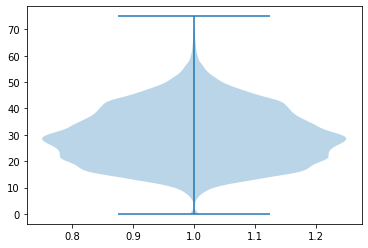

In [ ]:
ksc_mappings_df =getCustomKSCMappingsEdit()
TestWithCluster = createTestWithCluster(ksc_mappings_df)
print('Number of cluster in the test data are ',len(TestWithCluster.KSCClusterName.unique().tolist()))


label_name = 'KSCText'
merged_test_train_data=preProcessDeepLearning(TestWithCluster,TestWithCluster,label_name)

# pass the chapter which you want as label in you data 
# it gives the merged train and test data with appropiate column nanmes 
uniq_label_list = merged_test_train_data['label'].unique().tolist()
no_labels = len(uniq_label_list)
merged_test_train_data['label_code'] = [uniq_label_list.index(label) for label in merged_test_train_data['label'].tolist()] 

corpus=  merged_test_train_data 
corpus['label'] = corpus['label_code']
corpus.drop('label_code',axis= 1, inplace = True)
print('No of unique',label_name, 'are',no_labels)

## Do pre processing 

# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing

test_x = list(corpus[corpus.split=='test'].sentence)
test_y = np.array(corpus[corpus.split=='test'].label)

test_x  = preProcess(test_x)
test_x= test_x[0 : round(len(test_x)/2)]

Xtest = tokenizer_total.texts_to_matrix(test_x, mode='freq')

trial_data = TestWithCluster

In [ ]:
pred_seq_wise_text= accuracyTopThreeKSCText(Xtest)
print('Accuracy with top 3 KSC when matching with cluster is',sum(pred_seq_wise_text)/len(pred_seq_wise_text) * 100)


Accuracy with top 3 KSC when matching with cluster is 66.02409638554217


In [ ]:
pred_seq_wise_cluster = accuracyTopThreeKSCClsuter(Xtest,TestWithCluster)
print('Accuracy with top 3 KSC when matching with cluster is',sum(pred_seq_wise_cluster)/len(pred_seq_wise_cluster) * 100)


Accuracy with top 3 KSC when matching with cluster is 66.56626506024097


### Not much increse in accuracy is observed when using edit distance as metric 